# BIBLIOTECAS

In [1]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import matplotlib.colors as mcolors

# Estatística e análise
import scipy.stats as stats
from scipy.stats import fisher_exact, linregress
from itertools import combinations
from scipy.stats import ks_2samp
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr

# Geoprocessamento
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
from geobr import read_state

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from scipy.stats import sem  # Para calcular o erro padrão

# Otimização
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value

# Conexão com banco de dados
import psycopg2

# Configurações e ajustes
import warnings
import unicodedata
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
# Ocultar warnings
warnings.filterwarnings("ignore")

# Configurações de exibição
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
from sklearn.model_selection import StratifiedKFold
import geopandas as gpd
from shapely import wkt

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from geobr import read_state

# Importando as bibliotecas necessárias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

/home/deboragomes/.local/share/virtualenvs/debora-a-xJ3oPA/lib/python3.10/site-packages/geopandas/_compat.py:154: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()
/tmp/ipykernel_362036/146709028.py:22: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


# BASES

## salesforce

In [2]:
# salesforce
salesforce = pd.read_excel("data/relatorio_falcon_salesforce.xlsx")

# Excluir as linhas onde "Cliente" é "Transportadora Teste Salesforce"
salesforce = salesforce[salesforce['Cliente'] != 'Transportadora Teste Salesforce']

# Excluir as colunas especificadas
colunas_para_excluir = ['Contrato PX (qtde)', 'Atividade (qtde)', 'Unnamed: 1', 'Origem','Cliente','Saída','Contrato PX: Data de criação','Data de criação','Data','Contrato PX: Nº Contrato PX']
salesforce = salesforce.drop(columns=colunas_para_excluir, errors='ignore')

salesforce = salesforce.rename(columns={'ID Torre': 'freight_id',
                                        'Data e hora de conclusão': 'dh_falcon',
                                        'Status':'freight_status',
                                        'UF': 'uf',
                                        'Tipo': 'de_type',
                                        'Motorista': 'encontrou_motorista',
                                        "Assunto": "atividade_falcon",
                                        "Criado por" : 'criado_por'})

salesforce['dh_falcon'] = pd.to_datetime(salesforce['dh_falcon'])
salesforce = salesforce.sort_values(by=['freight_id', "dh_falcon"])

salesforce['encontrou_motorista'] = salesforce['encontrou_motorista'].apply(lambda x: 'nao' if pd.isna(x) else 'sim')
salesforce.head()

,criado_por,freight_id,freight_status,de_type,uf,encontrou_motorista,dh_falcon,atividade_falcon
64,Moana Santos,5261,Cancelada,Diária,MG,nao,2025-02-21 17:40:00,Envio de Whatsapp ativo Ofertas contrato longas
62,Leonardo Chaves,23414,Cancelada,Coleta/Entrega,PE,nao,2025-03-17 14:43:00,"Você ligou para 051997576397 em sexta-feira, 2..."
63,José Vitoriano Alves,23442,Cancelada,Coleta/Entrega,RN,nao,2025-02-17 08:39:00,Envio de Whatsapp ativo Ofertas contrato longas
71,José Vitoriano Alves,43547,Finalizada,Diária,SP,sim,2025-01-31 14:26:00,Envio de Whatsapp ativo Ofertas contrato longas
74,José Vitoriano Alves,43547,Finalizada,Diária,SP,sim,2025-01-31 14:27:00,Envio de Whatsapp ativo Ofertas contrato longas


In [3]:
# informações salesforce
print('Mínimo:', salesforce.dh_falcon.min())
print('Máximo:', salesforce.dh_falcon.max())

print('Quantidade de contratos:', salesforce.freight_id.nunique())

Mínimo: 2024-12-18 09:14:00
Máximo: 2025-03-18 11:29:00
Quantidade de contratos: 2758


In [4]:
# salesforce_resumo
salesforce_resumo = salesforce.groupby(['freight_id', 'de_type', 'uf','freight_status', 'encontrou_motorista']).agg(
    qt_atividades_falcon=('dh_falcon', 'count'),
    first_atividade_falcon=('dh_falcon', 'min'),
    last_atividade_falcon=('dh_falcon', 'max'),
).reset_index()

salesforce_resumo.head(3)

,freight_id,de_type,uf,freight_status,encontrou_motorista,qt_atividades_falcon,first_atividade_falcon,last_atividade_falcon
0,5261,Diária,MG,Cancelada,nao,1,2025-02-21 17:40:00,2025-02-21 17:40:00
1,23414,Coleta/Entrega,PE,Cancelada,nao,1,2025-03-17 14:43:00,2025-03-17 14:43:00
2,23442,Coleta/Entrega,RN,Cancelada,nao,1,2025-02-17 08:39:00,2025-02-17 08:39:00


In [5]:
# placeholders (pegando os contratos que falcon atuou para as próximas queries)

# Converter os valores para tipos nativos do Python (int)
salesforce_ids_filtrados = [int(fid) for fid in salesforce_resumo['freight_id'].unique()]
# Criar placeholders (%s, %s, %s...) para a query SQL
placeholders = ", ".join(["%s"] * len(salesforce_ids_filtrados))

## contratos

In [6]:
# contratos

conn = psycopg2.connect(
    dbname="px",
    user="debora_gomes",
    password="hT817qrR5uf41xh7Vlh5T",
    host="localhost",
    port="43561",
)
cursor = conn.cursor()

query = f"""
SELECT 
    f.type,
    public.freights_type(f.type) AS de_type,
    CASE 
        WHEN f.status = 900 THEN 'sim'
        ELSE 'nao'
    END AS foi_cancelada, 
    f.id AS freight_id,
    f.start_at, 
    f.vehicle_id,
    v.name AS vehicle,  
    f.price / 100 AS price,
    f.contract_days,
    f.status,
    public.freights_status(f.status) AS de_status,
    f.status,   
    ca.state_id,
    ca.latitude,
    ca.longitude,
    s.uf
FROM freights f
LEFT JOIN vehicles v ON f.vehicle_id = v.id  
LEFT JOIN company_addresses ca ON ca.id = f.origin
LEFT JOIN public.states s ON ca.state_id = s.id -- Join com a tabela states
WHERE f.id IN ({placeholders})
AND  f.start_at >= '2024-07-01'
AND f.start_at < CURRENT_DATE
AND f.company_id NOT IN (
      SELECT id 
      FROM companies 
      WHERE company_multitenancy_id = 5
);
    
"""

cursor.execute(query, tuple(salesforce_ids_filtrados))

contratos = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
contratos = pd.DataFrame(contratos, columns=colnames)

cursor.close()
conn.close()


contratos['vehicle'] = contratos['vehicle'].str.replace(r'^Carreta.*', 'Carreta', regex=True)
contratos['vehicle'] = contratos['vehicle'].str.replace(r'^Manobrista.*', 'Manobrista', regex=True)
contratos['vehicle'] = contratos['vehicle'].str.replace(r'^Truck.*', 'Truck', regex=True)

contratos['mes'] = pd.to_datetime(contratos['start_at']).dt.to_period('M').dt.to_timestamp()
contratos = contratos.sort_values(by=['freight_id'])
contratos = contratos[['mes','start_at', 'freight_id','de_status','vehicle','price', 'contract_days', 'uf', 'latitude']]

contratos = contratos.loc[contratos.contract_days > 0]
contratos.head(3)

,mes,start_at,freight_id,de_status,vehicle,price,contract_days,uf,latitude
0,2025-01-01,2025-01-13 07:30:00,103104,Cancelada,Toco,560,2,RS,-31.74
1,2025-01-01,2025-01-08 08:00:00,121669,Cancelada,Vanderleia,2440,8,MG,-22.87
2,2024-11-01,2024-11-28 04:00:00,124925,Cancelada,Carreta,320,1,SP,-23.52


In [7]:
contratos.freight_id.nunique()

2748

## base

In [8]:
# base
base = contratos.merge(salesforce_resumo, on=['freight_id','uf'], how='left')

base['start_at'] = pd.to_datetime(base['start_at'])
base['first_atividade_falcon'] = pd.to_datetime(base['first_atividade_falcon'])
base['last_atividade_falcon'] = pd.to_datetime(base['last_atividade_falcon'])

base['price_por_dia'] = base['price']/base['contract_days']

base['qt_horas_falcon'] = (base['last_atividade_falcon'] - base['first_atividade_falcon']).dt.total_seconds() / 60


base = base[['mes', 'uf', 'de_type', 'freight_id', 'vehicle', 'price','price_por_dia','contract_days', 
       'encontrou_motorista', 'qt_atividades_falcon',  'qt_horas_falcon']]

base.head(3)

,mes,uf,de_type,freight_id,vehicle,price,price_por_dia,contract_days,encontrou_motorista,qt_atividades_falcon,qt_horas_falcon
0,2025-01-01,RS,Coleta/Entrega,103104,Toco,560,280.00,2,nao,1.00,0.00
1,2025-01-01,MG,Coleta/Entrega,121669,Vanderleia,2440,305.00,8,nao,3.00,9.00
2,2024-11-01,SP,Diária,124925,Carreta,320,320.00,1,nao,1.00,0.00


In [9]:
# substiuindo qt_horas_falcon 0 (nao foi possivel fazer a diferença de valores) pelo valor mínimo


# Calcular o mínimo de qt_horas_falcon por UF, de_type e qt_atividades_falcon (ignorando valores 0)
min_por_estado_tipo_atividade = (
    base.loc[base["qt_horas_falcon"] > 0]
    .groupby(["uf", "de_type", "qt_atividades_falcon"])["qt_horas_falcon"]
    .min()
    .reset_index()
)

# Criar um dicionário para mapeamento eficiente
min_mapeamento = min_por_estado_tipo_atividade.set_index(["uf", "de_type", "qt_atividades_falcon"])["qt_horas_falcon"].to_dict()

# Calcular o mínimo de qt_horas_falcon apenas por de_type e qt_atividades_falcon (ignorando valores 0)
min_por_tipo_duracao = (
    base.loc[base["qt_horas_falcon"] > 0]
    .groupby(["de_type", "qt_atividades_falcon"])["qt_horas_falcon"]
    .min()
    .reset_index()
)

# Criar um dicionário para fallback caso não haja dados por UF
min_mapeamento_tipo_duracao = min_por_tipo_duracao.set_index(["de_type", "qt_atividades_falcon"])["qt_horas_falcon"].to_dict()

# Calcular o mínimo geral como último fallback
min_geral = base.loc[base["qt_horas_falcon"] > 0, "qt_horas_falcon"].min()

# Aplicar a substituição dos valores 0
def substituir_qt_horas(row):
    if row["qt_horas_falcon"] == 0:
        return min_mapeamento.get(
            (row["uf"], row["de_type"], row["qt_atividades_falcon"]),
            min_mapeamento_tipo_duracao.get((row["de_type"], row["qt_atividades_falcon"]), min_geral)
        )
    return row["qt_horas_falcon"]

# Aplicar a função na base
base["qt_horas_falcon_ajus"] = base.apply(substituir_qt_horas, axis=1)

base.to_csv('base.csv', index=False)
base.head(3)


,mes,uf,de_type,freight_id,vehicle,price,price_por_dia,contract_days,encontrou_motorista,qt_atividades_falcon,qt_horas_falcon,qt_horas_falcon_ajus
0,2025-01-01,RS,Coleta/Entrega,103104,Toco,560,280.00,2,nao,1.00,0.00,1.00
1,2025-01-01,MG,Coleta/Entrega,121669,Vanderleia,2440,305.00,8,nao,3.00,9.00,9.00
2,2024-11-01,SP,Diária,124925,Carreta,320,320.00,1,nao,1.00,0.00,1.00


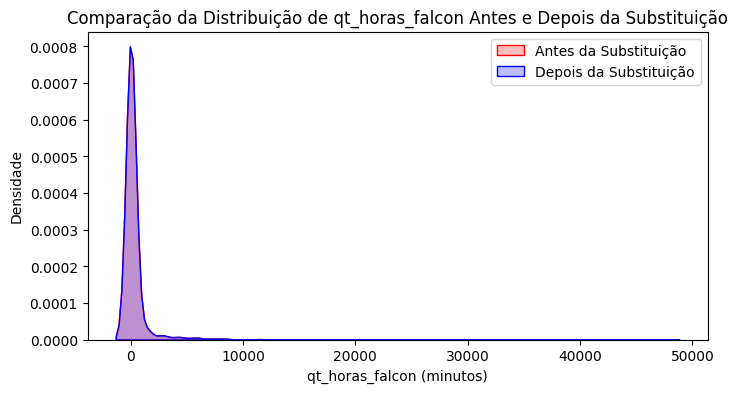


📊 Estatísticas descritivas antes e depois da substituição:
       qt_horas_falcon  qt_horas_falcon_ajus
count          2743.00               2743.00
mean            407.90                408.31
std            2165.90               2165.84
min               0.00                  1.00
25%               1.00                  1.00
50%               2.00                  2.00
75%               9.00                  9.00
max           47511.00              47511.00

📊 Teste de Wilcoxon:
Estatística do Teste: 0.0000, p-valor: 0.0000

🔹 Há uma diferença estatisticamente significativa entre as distribuições antes e depois da substituição!


In [10]:
# comparando se a substituição foi eficiente
base["qt_horas_falcon"] = pd.to_numeric(base["qt_horas_falcon"], errors="coerce")
base["qt_horas_falcon_ajus"] = pd.to_numeric(base["qt_horas_falcon_ajus"], errors="coerce")

# Remover valores nulos para evitar problemas na análise
base = base.dropna(subset=["qt_horas_falcon", "qt_horas_falcon_ajus"])


plt.figure(figsize=(8, 4))
sns.kdeplot(base["qt_horas_falcon"], label="Antes da Substituição", shade=True, color="red")
sns.kdeplot(base["qt_horas_falcon_ajus"], label="Depois da Substituição", shade=True, color="blue")
plt.title("Comparação da Distribuição de qt_horas_falcon Antes e Depois da Substituição")
plt.xlabel("qt_horas_falcon (minutos)")
plt.ylabel("Densidade")
plt.legend()
plt.show()


estatisticas = base[["qt_horas_falcon", "qt_horas_falcon_ajus"]].describe()

# - O teste de Wilcoxon é adequado para comparar distribuições pareadas não normais.
stat_test = stats.wilcoxon(base["qt_horas_falcon"], base["qt_horas_falcon_ajus"])

#  Exibir os resultados
print("\n📊 Estatísticas descritivas antes e depois da substituição:")
print(estatisticas)

print("\n📊 Teste de Wilcoxon:")
print(f"Estatística do Teste: {stat_test.statistic:.4f}, p-valor: {stat_test.pvalue:.4f}")

# 📌 Interpretação do teste
if stat_test.pvalue < 0.05:
    print("\n🔹 Há uma diferença estatisticamente significativa entre as distribuições antes e depois da substituição!")
else:
    print("\n✅ Não há diferença estatisticamente significativa entre as distribuições.")

In [11]:
# arrumando as colunas de base
base.drop(columns=["qt_horas_falcon"], inplace=True, errors="ignore")
base.rename(columns={"qt_horas_falcon_ajus": "qt_horas_falcon"}, inplace=True)

base.to_csv("base_final.csv", index=False)
base.head()

,mes,uf,de_type,freight_id,vehicle,price,price_por_dia,contract_days,encontrou_motorista,qt_atividades_falcon,qt_horas_falcon
0,2025-01-01,RS,Coleta/Entrega,103104,Toco,560,280.00,2,nao,1.00,1.00
1,2025-01-01,MG,Coleta/Entrega,121669,Vanderleia,2440,305.00,8,nao,3.00,9.00
2,2024-11-01,SP,Diária,124925,Carreta,320,320.00,1,nao,1.00,1.00
3,2025-01-01,SP,Coleta/Entrega,126105,Utilitários,640,160.00,4,nao,7.00,1.00
4,2024-12-01,SP,Diária,127859,Rodotrem,5625,375.00,15,sim,2.00,4.00


## contratos_falcon

In [12]:
contratos_falcon = base[['freight_id']].copy()
contratos_falcon['atuacao_falcon'] = 'sim'
contratos_falcon.head(3)

,freight_id,atuacao_falcon
0,103104,sim
1,121669,sim
2,124925,sim


## todos_contratos

In [13]:
# todos_contratos
conn = psycopg2.connect(
    dbname="px",
    user="debora_gomes",
    password="hT817qrR5uf41xh7Vlh5T",
    host="localhost",
    port="43561",
)
cursor = conn.cursor()

cursor.execute(f"""

    SELECT 
        f.type,
        public.freights_type(f.type) AS de_type,
        f.status,
        public.freights_status(f.status) AS de_status,
        CASE 
            WHEN f.status = 900 THEN 'sim'
            ELSE 'nao'
        END AS foi_cancelada, 
        f.start_at,
        f.id AS freight_id,
        f.vehicle_id,
        v.name AS vehicle,  
        f.price / 100 AS price,
        f.contract_days,
        f.company_id,
        f.driver_id,
        ca.city_id,
        ca.state_id,
        s.uf,
        ct.name as city,
        CASE 
            WHEN uwf.freight_id IS NOT NULL THEN 'sim'
            ELSE 'nao'
        END AS atuacao_falcon
    FROM freights f
    LEFT JOIN (
        SELECT DISTINCT freight_id
        FROM user_working_freights
    ) uwf ON uwf.freight_id = f.id
    LEFT JOIN companies c ON c.id = f.company_id
    LEFT JOIN vehicles v ON f.vehicle_id = v.id  
    LEFT JOIN company_addresses ca ON ca.id = f.origin
    LEFT JOIN public.states s ON ca.state_id = s.id
    LEFT JOIN public.cities ct ON ca.city_id = ct.id
    WHERE f.start_at >= '2024-12-31'
      AND f.company_id NOT IN (
          SELECT id 
          FROM companies 
          WHERE company_multitenancy_id = 5
      )
    ORDER BY f.start_at ASC;
""")


todos_contratos = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
todos_contratos = pd.DataFrame(todos_contratos, columns=colnames)

cursor.close()
conn.close()

todos_contratos['mes'] = pd.to_datetime(todos_contratos['start_at']).dt.to_period('M').dt.to_timestamp()

todos_contratos['vehicle'] = todos_contratos['vehicle'].str.replace(r'^Carreta.*', 'Carreta', regex=True)
todos_contratos['vehicle'] = todos_contratos['vehicle'].str.replace(r'^Manobrista.*', 'Manobrista', regex=True)
todos_contratos['vehicle'] = todos_contratos['vehicle'].str.replace(r'^Truck.*', 'Truck', regex=True)


todos_contratos = todos_contratos.loc[(todos_contratos.mes > '2024-12-01')&(todos_contratos.start_at < '2025-03-26')]
todos_contratos = todos_contratos.sort_values(by=['freight_id'])

todos_contratos = todos_contratos.loc[todos_contratos.contract_days > 0]
todos_contratos['price_por_dia'] = todos_contratos['price']/todos_contratos['contract_days']

todos_contratos = todos_contratos[['freight_id', 'uf','de_type','vehicle','driver_id','company_id','price_por_dia','contract_days','foi_cancelada', 'city']]

todos_contratos = todos_contratos.merge(contratos_falcon, on='freight_id', how = 'left')

todos_contratos = todos_contratos[['freight_id', 'uf','city','de_type','vehicle','driver_id','company_id','price_por_dia','contract_days','foi_cancelada','atuacao_falcon']]

todos_contratos['atuacao_falcon'] = todos_contratos['atuacao_falcon'].fillna('nao')


rms_municipios = [
    'São Paulo', 'Arujá', 'Barueri', 'Biritiba Mirim', 'Caieiras', 'Cajamar', 'Carapicuíba',
    'Cotia', 'Diadema', 'Embu das Artes', 'Embu-Guaçu', 'Ferraz de Vasconcelos', 'Francisco Morato',
    'Franco da Rocha', 'Guararema', 'Guarulhos', 'Itapecerica da Serra', 'Itapevi', 'Itaquaquecetuba',
    'Jandira', 'Juquitiba', 'Mairiporã', 'Mauá', 'Mogi das Cruzes', 'Osasco', 'Pirapora do Bom Jesus',
    'Poá', 'Ribeirão Pires', 'Rio Grande da Serra', 'Salesópolis', 'Santa Isabel', 'Santana de Parnaíba',
    'Santo André', 'São Bernardo do Campo', 'São Caetano do Sul', 'São Lourenço da Serra', 'Suzano',
    'Taboão da Serra', 'Vargem Grande Paulista'
]

# Atualizar a coluna 'uf' para 'SP_RM' onde a cidade está na lista da RMSP e a uf for SP
todos_contratos['uf'] = todos_contratos.apply(
    lambda row: 'SP_RM' if row['uf'] == 'SP' and row['city'] in rms_municipios else row['uf'],
    axis=1
)

todos_contratos.to_csv('todos_contratos.csv', index=False)

resumo_todos_contratos = todos_contratos[['freight_id','uf']]
display(todos_contratos.head(3))


,freight_id,uf,city,de_type,vehicle,driver_id,company_id,price_por_dia,contract_days,foi_cancelada,atuacao_falcon
0,103104,RS,Pelotas,Coleta/Entrega,Toco,NaN,1972,280.00,2,sim,sim
1,121669,MG,Extrema,Coleta/Entrega,Vanderleia,NaN,3372,305.00,8,sim,sim
2,121724,MG,Extrema,Coleta/Entrega,Vanderleia,NaN,3372,305.00,8,sim,nao


In [14]:
todos_contratos.loc[(todos_contratos.de_type == 'Coleta/Entrega')&(todos_contratos.uf == 'SE')]

,freight_id,uf,city,de_type,vehicle,driver_id,company_id,price_por_dia,contract_days,foi_cancelada,atuacao_falcon
11471,143753,SE,Nossa Senhora do Socorro,Coleta/Entrega,Carreta,90994.00,3337,305.00,1,nao,nao
12678,144960,SE,Nossa Senhora do Socorro,Coleta/Entrega,Truck,90994.00,3337,260.00,4,nao,nao
13226,145510,SE,Nossa Senhora do Socorro,Coleta/Entrega,Cavalinho,51764.00,3860,298.00,2,nao,sim
15052,147339,SE,Nossa Senhora do Socorro,Coleta/Entrega,Toco,22181.00,2782,230.00,20,nao,nao
17264,149558,SE,Aracaju,Coleta/Entrega,Toco,55949.00,3934,230.00,2,nao,nao


In [15]:
todos_contratos.loc[todos_contratos.de_type == 'Coleta/Entrega'].uf.value_counts()

uf
SP_RM    2136
SP       1195
RJ        448
MG        444
SC        391
PR        345
RS        305
GO        144
MS        107
BA         90
ES         70
PE         69
CE         42
MT         38
MA         27
PB         23
AL         17
PI         15
PA         10
RN          5
SE          5
DF          2
AM          1
Name: count, dtype: int64

In [16]:
# contagens

print('Quantidade total de contratos no período:', len(todos_contratos))

print('Quantidade total de contratos cancelados no período:', 
      todos_contratos['foi_cancelada'].value_counts().get('sim', 0))

print('Quantidade total de contratos com atuação Falcon no período:', 
      todos_contratos['atuacao_falcon'].value_counts().get('sim', 0))

Quantidade total de contratos no período: 19991
Quantidade total de contratos cancelados no período: 3770
Quantidade total de contratos com atuação Falcon no período: 2646


In [17]:
# resumo_estados

# Mapeando colunas categóricas para valores numéricos
todos_contratos['foi_cancelada'] = todos_contratos['foi_cancelada'].map({'sim': 1, 'nao': 0})

if 'atuacao_falcon' in todos_contratos.columns:
    todos_contratos['atuacao_falcon'] = todos_contratos['atuacao_falcon'].map({'sim': 1, 'nao': 0})
else:
    todos_contratos['atuacao_falcon'] = 0  # Se não existir, assume-se que não houve atuação

# Calculando métricas principais por estado e tipo de contrato
resumo_estados = todos_contratos.groupby(['uf', 'de_type']).agg(
    total_contratos=('price_por_dia', 'count'),
    qt_motoristas = ('driver_id', 'nunique'),
    qt_companies = ('company_id', 'nunique'),
    percentual_cancelados=('foi_cancelada', 'mean'),
    percentual_atuacao_falcon=('atuacao_falcon', 'mean'),
    preco_medio=('price_por_dia', 'mean')
).reset_index()

# Calculando referência de preço médio para cada tipo de contrato
referencia_precos = todos_contratos.groupby('de_type')['price_por_dia'].mean().rename('preco_medio_referencia')
qt_motoristas = todos_contratos.groupby('uf')['driver_id'].nunique().rename('preco_medio_referencia')

# Adicionando a referência ao resumo
resumo_estados = resumo_estados.merge(referencia_precos, on='de_type')


# Calculando preço médio para contratos com atuação do Falcon
preco_falcon = todos_contratos[todos_contratos['atuacao_falcon'] == 1].groupby(['uf', 'de_type'])['price_por_dia'].mean().rename('preco_medio_falcon').reset_index()

# Adicionando essa informação ao resumo
resumo_estados = resumo_estados.merge(preco_falcon, on=['uf', 'de_type'], how='left')

resumo_estados = resumo_estados.loc[resumo_estados.total_contratos > 9]
resumo_estados = resumo_estados.loc[resumo_estados.percentual_atuacao_falcon > 0]

resumo_estados['motorista/contrato'] = (resumo_estados['qt_motoristas'] / resumo_estados['total_contratos']).round(2)
resumo_estados['motorista/transportadora'] = (resumo_estados['qt_motoristas'] / resumo_estados['qt_companies']).round(2)

resumo_estados.to_csv("resumo_estados.csv", index=False)
resumo_estados.head(3)


,uf,de_type,total_contratos,qt_motoristas,qt_companies,percentual_cancelados,percentual_atuacao_falcon,preco_medio,preco_medio_referencia,preco_medio_falcon,motorista/contrato,motorista/transportadora
4,BA,Ajudante,20,8,5,0.50,0.40,133.04,161.75,128.38,0.40,1.60
5,BA,Coleta/Entrega,90,31,12,0.12,0.07,242.70,256.11,240.87,0.34,2.58
6,BA,Diária,133,54,25,0.19,0.08,318.75,326.83,302.00,0.41,2.16


## base_sem_out

In [18]:
# base_sem_out (removendo outliers)
base_sem_out = base.copy()
def remove_outliers(base, column):
    Q1 = base_sem_out[column].quantile(0.25)
    Q3 = base_sem_out[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    return base[(base_sem_out[column] >= lower_bound) & (base_sem_out[column] <= upper_bound)]

# Aplicar a remoção de outliers para as colunas críticas
columns_to_clean = ['qt_atividades_falcon', 'qt_horas_falcon']

for col in columns_to_clean:
    base_sem_out = remove_outliers(base_sem_out, col)

base_sem_out = base_sem_out.merge(resumo_todos_contratos, on='freight_id', how='left')

# Remover a coluna 'uf_x'
base_sem_out = base_sem_out.drop(columns=['uf_x'])

# Renomear 'uf_y' para 'uf'
base_sem_out = base_sem_out.rename(columns={'uf_y': 'uf'})
base_sem_out = base_sem_out[['uf','mes', 'de_type', 'freight_id', 'price', 'price_por_dia',
       'contract_days', 'encontrou_motorista', 'qt_atividades_falcon','qt_horas_falcon']]

base_sem_out = base_sem_out.dropna()
base_sem_out

,uf,mes,de_type,freight_id,price,price_por_dia,contract_days,encontrou_motorista,qt_atividades_falcon,qt_horas_falcon
0,RS,2025-01-01,Coleta/Entrega,103104,560,280.00,2,nao,1.00,1.00
1,MG,2025-01-01,Coleta/Entrega,121669,2440,305.00,8,nao,3.00,9.00
3,SP,2025-01-01,Coleta/Entrega,126105,640,160.00,4,nao,7.00,1.00
10,MS,2025-01-01,Ajudante,128728,300,150.00,2,sim,5.00,2.00
18,DF,2025-01-01,Diária,130131,4575,305.00,15,sim,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...
2258,SP_RM,2025-03-01,Ajudante,150546,100,100.00,1,sim,4.00,1.00
2259,MG,2025-03-01,Ajudante,150547,139,139.00,1,nao,10.00,2.00
2260,MG,2025-03-01,Ajudante,150548,150,150.00,1,nao,3.00,2.00
2261,SP_RM,2025-03-01,Diária,150550,3720,372.00,10,nao,30.00,15.00


In [19]:
# Verificar no mínimo 10 dados para cada estado

estatisticas_uf = base_sem_out.groupby("uf")["freight_id"].describe()

limite_minimo = 11

ufs_suficientes = estatisticas_uf[estatisticas_uf["count"] >= limite_minimo].index.tolist()
ufs_agrupados = estatisticas_uf[estatisticas_uf["count"] < limite_minimo].index.tolist()

ufs_agrupados_legenda = f"({', '.join(ufs_agrupados)})" if ufs_agrupados else "Nenhum agrupamento necessário"

base_sem_out["uf_ajustado"] = base_sem_out["uf"].apply(lambda x: x if x in ufs_suficientes else ufs_agrupados_legenda)

print("Estados Individuais:", ufs_suficientes)
print("Estados Agrupados:", ufs_agrupados_legenda)

# Garantir que 'encontrou_motorista' seja numérico (0 ou 1)
base_sem_out['sucesso'] = base_sem_out['encontrou_motorista'].map({'sim': 1, 'nao': 0})

# Garantir que não há zeros para evitar erros de divisão
base_sem_out['qt_atividades_falcon'].replace(0, 1, inplace=True)
base_sem_out['qt_horas_falcon'].replace(0, 1, inplace=True)


# **Remover NaNs apenas onde necessário**
base_sem_out.dropna(subset=['qt_atividades_falcon', 'qt_horas_falcon', 'contract_days', 'encontrou_motorista'], inplace=True)

base_sem_out.to_csv('base_sem_out.csv', index=False)
base_sem_out.head(3)

Estados Individuais: ['BA', 'CE', 'ES', 'GO', 'MG', 'MS', 'MT', 'PB', 'PE', 'PR', 'RJ', 'RS', 'SC', 'SP', 'SP_RM']
Estados Agrupados: (AL, DF, MA, PA, RN, SE)


,uf,mes,de_type,freight_id,price,price_por_dia,contract_days,encontrou_motorista,qt_atividades_falcon,qt_horas_falcon,uf_ajustado,sucesso
0,RS,2025-01-01,Coleta/Entrega,103104,560,280.00,2,nao,1.00,1.00,RS,0
1,MG,2025-01-01,Coleta/Entrega,121669,2440,305.00,8,nao,3.00,9.00,MG,0
3,SP,2025-01-01,Coleta/Entrega,126105,640,160.00,4,nao,7.00,1.00,SP,0


In [20]:
base_sem_out.describe()

,mes,freight_id,price,price_por_dia,contract_days,qt_atividades_falcon,qt_horas_falcon,sucesso
count,2184,2184.00,2184.00,2184.00,2184.00,2184.00,2184.00,2184.00
mean,2025-01-28 12:48:47.472527360,141730.98,1716.61,246.69,6.05,7.64,3.63,0.72
min,2025-01-01 00:00:00,103104.00,100.00,75.00,1.00,1.00,1.00,0.00
25%,2025-01-01 00:00:00,137834.00,260.00,170.00,1.00,4.00,1.00,0.00
50%,2025-02-01 00:00:00,141773.50,640.00,260.00,3.00,7.00,2.00,1.00
75%,2025-02-01 00:00:00,145461.25,1860.00,305.00,7.00,11.00,4.00,1.00
max,2025-03-01 00:00:00,150563.00,19825.00,476.67,61.00,34.00,29.00,1.00
std,NaN,4907.24,2554.35,76.48,8.01,4.81,4.68,0.45


# BASES COM MEDIDAS CALCULADAS

## base_resultado

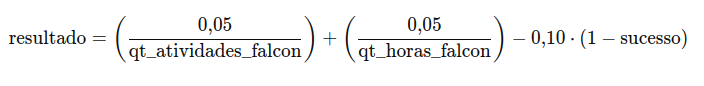

Está medindo o quão bem um contrato foi resolvido com o menor esforço possível da equipe.

Quanto mais atividades forem feitas, menor a eficiência 

Quanto mais tempo for necessário, menor a eficiência

Penaliza fortemente os casos que **não resultaram em motorista** 




In [21]:
# base_resultado

# Preparar os dados
df = base_sem_out.copy()

# Substituir 0 por NaN e remover linhas com dados faltando
df['qt_atividades_falcon'] = df['qt_atividades_falcon'].replace(0, np.nan)
df['qt_horas_falcon'] = df['qt_horas_falcon'].replace(0, np.nan)
df.dropna(subset=['qt_atividades_falcon', 'qt_horas_falcon'], inplace=True)

# Converter encontrou_motorista para binário
df['sucesso'] = (df['encontrou_motorista'] == 'sim').astype(int)

# Faixas de pesos a testar
alpha_values = np.arange(0.05, 1.05, 0.05)
beta_values = np.arange(0.05, 1.05, 0.05)
gamma_values = np.arange(0.05, 1.05, 0.05)

best_auc = 0
best_params = None
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for alpha in alpha_values:
    for beta in beta_values:
        for gamma in gamma_values:
            # Calcular eficiência temporária
            df['resultado_temp'] = (
                (alpha / df['qt_atividades_falcon']) +
                (beta / df['qt_horas_falcon']) -
                gamma * (1 - df['sucesso'])
            )

            X = df[['resultado_temp']]
            y = df['sucesso']

            # Avaliar com cross-validation
            aucs = []
            for train_idx, test_idx in kf.split(X, y):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

                model = LogisticRegression(solver='liblinear')
                model.fit(X_train, y_train)
                y_pred_proba = model.predict_proba(X_test)[:, 1]
                auc = roc_auc_score(y_test, y_pred_proba)
                aucs.append(auc)

            mean_auc = np.mean(aucs)

            if mean_auc > best_auc:
                best_auc = mean_auc
                best_params = (alpha, beta, gamma)

# Aplicar os melhores pesos na base final
alpha_best, beta_best, gamma_best = best_params

df['resultado'] = (
    (alpha_best / df['qt_atividades_falcon']) +
    (beta_best / df['qt_horas_falcon']) -
    gamma_best * (1 - df['sucesso'])
)

print(f"✅ Melhores pesos encontrados (cross-val): alpha={alpha_best:.2f}, beta={beta_best:.2f}, gamma={gamma_best:.2f}")

def remover_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_superior = Q3 + 1.5 * IQR

    total_antes = len(df)
    df_filtrado = df[df[col] <= limite_superior]
    total_depois = len(df_filtrado)
    removidos = total_antes - total_depois

    print(f"🔍 Coluna '{col}': {removidos} outliers removidos ({removidos / total_antes:.1%} do total)")
    
    return df_filtrado

df = remover_outliers(df, "resultado")

df["resultado"] = (df["resultado"] - df["resultado"].min()) / (df["resultado"].max() - df["resultado"].min())
base_resultado = df.copy()
base_resultado.head(3)


✅ Melhores pesos encontrados (cross-val): alpha=0.05, beta=0.05, gamma=0.10
🔍 Coluna 'resultado': 0 outliers removidos (0.0% do total)


,uf,mes,de_type,freight_id,price,price_por_dia,contract_days,encontrou_motorista,qt_atividades_falcon,qt_horas_falcon,uf_ajustado,sucesso,resultado_temp,resultado
0,RS,2025-01-01,Coleta/Entrega,103104,560,280.00,2,nao,1.00,1.00,RS,0,1.00,0.49
1,MG,2025-01-01,Coleta/Entrega,121669,2440,305.00,8,nao,3.00,9.00,MG,0,-0.56,0.09
3,SP,2025-01-01,Coleta/Entrega,126105,640,160.00,4,nao,7.00,1.00,SP,0,0.14,0.27


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Definir X (score de risco) e y (sucesso = encontrou motorista)
X = base_resultado[["resultado"]]
y = (base_resultado["sucesso"] == 1)  # ou base_resultado["encontrou_motorista"] se já estiver binário

# Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Treinar modelo
logistic_model = LogisticRegression(C=1.0, solver="liblinear")
logistic_model.fit(X_train, y_train)

# Previsões
y_pred = logistic_model.predict(X_test)
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

# Avaliação
roc_auc = roc_auc_score(y_test, y_pred_proba)
relatorio_classificacao = classification_report(y_test, y_pred)

# Resultados
print(f"AUC-ROC: {roc_auc:.3f}")
print("📋 Relatório de Classificação:")
print(relatorio_classificacao)


AUC-ROC: 1.000
📋 Relatório de Classificação:
              precision    recall  f1-score   support

       False       1.00      0.91      0.95       186
        True       0.97      1.00      0.98       470

    accuracy                           0.97       656
   macro avg       0.98      0.95      0.97       656
weighted avg       0.97      0.97      0.97       656



## base_resultado_esforco

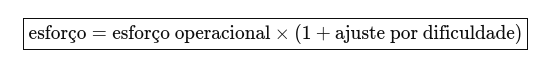

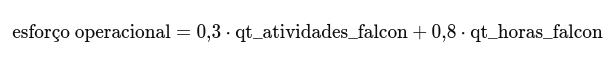

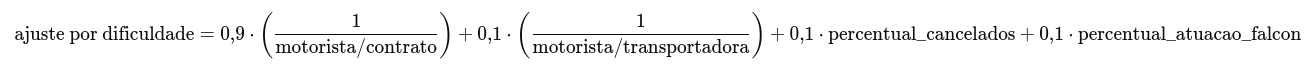

**Esforço Operacional** -> Medida do trabalho direto realizado pelo time Falcon               |

- Mais atividades→ mais esforço
- Mais horas gastas → mais esforço

**Ajuste por dificuldade** -> ajusta o esforço de acordo com **a dificuldade operacional do estado e tipo de contrato (ajudante, diária, coleta/entrega)**:

- Poucos motoristas por contrato = mais difícil              |
- Poucos motoristas por empresa = mais esforço                        |
- Regiões com muitos cancelamentos indicam instabilidade operacional           |
- Se o Falcon atua muito na região, ela provavelmente é mais crítica/demandante 

**Esforço**

- O esforço aumenta **com mais trabalho e mais dificuldade regional**.
- Regiões com **baixa oferta de motoristas por contrato** pesam mais.
- Ajuda a entender **onde o time está sobrecarregado**.

In [23]:
# base_resultado_esforco

from itertools import product

# Merge da base principal com os dados de contexto
df = base_resultado.merge(resumo_estados, on=["uf", "de_type"], how="left")

# Preparo das variáveis
df['encontrou_motorista'] = df['encontrou_motorista'].map({'sim': 1, 'nao': 0})
df['qt_atividades_falcon'].replace(0, 1, inplace=True)
df['qt_horas_falcon'].replace(0, 1, inplace=True)
df['contract_days'].replace(0, 1, inplace=True)

# Evitar divisão por zero em indicadores contextuais
df["motorista/contrato"].replace(0, np.nan, inplace=True)
df["motorista/transportadora"].replace(0, np.nan, inplace=True)

# Intervalos de busca
alpha_range = np.arange(0.3, 0.6, 0.05)
beta_range = np.arange(0.5, 0.8, 0.05)
gamma_range = np.arange(0.1, 1.05, 0.2)

best_score = float("inf")
best_params = {}

# Grid search para encontrar melhor combinação de pesos
for alpha, beta, g1, g2, g3, g4 in product(alpha_range, beta_range, gamma_range, gamma_range, gamma_range, gamma_range):
    
    # Esforço operacional
    esforco_op = (
        alpha * df["qt_atividades_falcon"] +
        beta * df["qt_horas_falcon"]
    )
    
    # Fator de contexto
    fator_contexto = (
        g1 * (1 / df["motorista/contrato"]) +
        g2 * (1 / df["motorista/transportadora"]) +
        g3 * df["percentual_cancelados"] +
        g4 * df["percentual_atuacao_falcon"]
    ).fillna(0)
    
    # Esforço final enriquecido
    esforco_final = esforco_op * (1 + fator_contexto)
    
    # Normalização
    esforco_norm = (esforco_final - esforco_final.min()) / (esforco_final.max() - esforco_final.min())
    
    # Score = variabilidade (quanto menor, melhor)
    score = esforco_norm.std()
    
    if score < best_score:
        best_score = score
        best_params = {
            "alpha": alpha,
            "beta": beta,
            "g1": g1,
            "g2": g2,
            "g3": g3,
            "g4": g4,
        }

# ✅ Recalcular o esforço com os melhores pesos e manter todas as colunas
alpha = best_params["alpha"]
beta = best_params["beta"]
g1 = best_params["g1"]
g2 = best_params["g2"]
g3 = best_params["g3"]
g4 = best_params["g4"]

# Esforço operacional (mantém no df)
df["esforco_operacional"] = (
    alpha * df["qt_atividades_falcon"] +
    beta * df["qt_horas_falcon"]
) 

# Fator de contexto (mantém no df)
df["fator_contexto"] = (
    g1 * (1 / df["motorista/contrato"]) +
    g2 * (1 / df["motorista/transportadora"]) +
    g3 * df["percentual_cancelados"] +
    g4 * df["percentual_atuacao_falcon"]
).fillna(0)

# Esforço final bruto
df["esforco_final"] = df["esforco_operacional"] * (1 + df["fator_contexto"])

def excluir_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_superior = Q3 + 1.5 * IQR

    # Filtra os não-outliers
    df_filtrado = df[df[col] <= limite_superior].copy()

    # Conta quantos foram excluídos
    excluidos = len(df) - len(df_filtrado)
    print(f"🔎 Outliers removidos na coluna '{col}': {excluidos} registros")

    return df_filtrado

    return df

df = excluir_outliers(df, 'esforco_final')
#df = limitar_outliers(df, "esforco_final")

# Esforço final normalizado (para modelo)
#df["esforco_final_log"] = np.log1p(df["esforco_final"])
#df["esforco"] = (df["esforco_final_log"] - df["esforco_final_log"].min()) / (df["esforco_final_log"].max() - df["esforco_final_log"].min())
df["esforco"] = (df["esforco_final"] - df["esforco_final"].min()) / (df["esforco_final"].max() - df["esforco_final"].min())

# Exibir os melhores pesos encontrados
print("🔎 Melhores Pesos Encontrados:")
for k, v in best_params.items():
    print(f"{k} = {v:.3f}")

#df.drop(columns=["esforco_operacional",	'fator_contexto',	'esforco_final', "esforco_final_log"], inplace=True)
df.drop(columns=["esforco_operacional",	'fator_contexto',	'esforco_final'], inplace=True)


base_resultado_esforco = df.copy()
base_resultado_esforco.head(3)


🔎 Outliers removidos na coluna 'esforco_final': 156 registros
🔎 Melhores Pesos Encontrados:
alpha = 0.300
beta = 0.800
g1 = 0.900
g2 = 0.100
g3 = 0.100
g4 = 0.100


,uf,mes,de_type,freight_id,price,price_por_dia,contract_days,encontrou_motorista,qt_atividades_falcon,qt_horas_falcon,uf_ajustado,sucesso,resultado_temp,resultado,total_contratos,qt_motoristas,qt_companies,percentual_cancelados,percentual_atuacao_falcon,preco_medio,preco_medio_referencia,preco_medio_falcon,motorista/contrato,motorista/transportadora,esforco
0,RS,2025-01-01,Coleta/Entrega,103104,560,280.00,2,0,1.00,1.00,RS,0,1.00,0.49,305.00,71.00,27.00,0.15,0.17,270.92,256.11,253.58,0.23,2.63,0.07
1,MG,2025-01-01,Coleta/Entrega,121669,2440,305.00,8,0,3.00,9.00,MG,0,-0.56,0.09,444.00,92.00,38.00,0.19,0.13,265.29,256.11,256.25,0.21,2.42,0.67
2,SP,2025-01-01,Coleta/Entrega,126105,640,160.00,4,0,7.00,1.00,SP,0,0.14,0.27,1195.00,310.00,87.00,0.19,0.17,264.49,256.11,256.08,0.26,3.56,0.19


## base_eficiencia

In [24]:
# base
base_eficiencia = base_resultado_esforco[['mes', 'uf', 'de_type', 'freight_id', 'price',
       'contract_days', 'encontrou_motorista', 'qt_atividades_falcon',
       'qt_horas_falcon', 'uf_ajustado',  'sucesso', 'resultado',  'esforco' ]]



base_eficiencia['eficiencia'] = base_eficiencia['resultado']/base_eficiencia['esforco']

def limitar_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_superior = Q3 + 1.5 * IQR

    # Maior valor não-outlier
    max_valido = df[df[col] <= limite_superior][col].max()

    # Substituir outliers
    df[col] = np.where(df[col] > limite_superior, max_valido, df[col])

    return df

base_eficiencia = limitar_outliers(base_eficiencia, "eficiencia")

base_eficiencia = base_eficiencia.loc[base_eficiencia.esforco != 0]

# Normalizar eficiência para escala 0-1
ef_min = base_eficiencia["eficiencia"].min()
ef_max = base_eficiencia["eficiencia"].max()

base_eficiencia["eficiencia"] = (
    (base_eficiencia["eficiencia"] - ef_min) / (ef_max - ef_min)
)

base_eficiencia.to_csv('base.csv', index=False)
base_eficiencia.head(3)

,mes,uf,de_type,freight_id,price,contract_days,encontrou_motorista,qt_atividades_falcon,qt_horas_falcon,uf_ajustado,sucesso,resultado,esforco,eficiencia
0,2025-01-01,RS,Coleta/Entrega,103104,560,2,0,1.00,1.00,RS,0,0.49,0.07,0.78
1,2025-01-01,MG,Coleta/Entrega,121669,2440,8,0,3.00,9.00,MG,0,0.09,0.67,0.01
2,2025-01-01,SP,Coleta/Entrega,126105,640,4,0,7.00,1.00,SP,0,0.27,0.19,0.16


# AVALIAÇÃO RESULTADO, ESFORÇO, EFICIENCIA

In [25]:
# cortes:

corte_resultado = 0.515
corte_esforco = 0.455
corte_eficiencia = 0.135


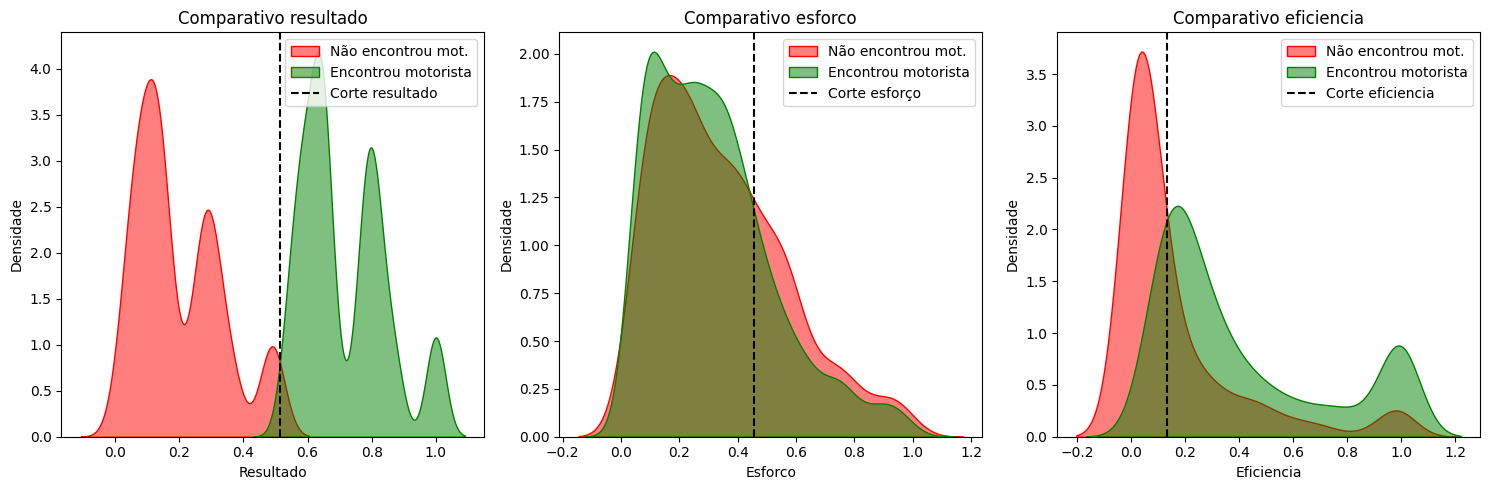

In [26]:
# gráficos comparativos 

base = base_eficiencia.copy()
# Filtrar os dados
df_nao = base[base["sucesso"] == 0]
df_sim = base[base["sucesso"] == 1]


# Criar KDE plots para "sim" e "não" na coluna encontrou_motorista
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


# KDE plots para resultado
sns.kdeplot(df_nao["resultado"], fill=True, color="red", alpha=0.5, label="Não encontrou mot.", ax=axes[0])
sns.kdeplot(df_sim["resultado"], fill=True, color="green", alpha=0.5, label="Encontrou motorista", ax=axes[0])
axes[0].axvline(corte_resultado, color='black', linestyle='--', label="Corte resultado")
axes[0].set_title("Comparativo resultado")
axes[0].set_xlabel("Resultado")
axes[0].set_ylabel("Densidade")
axes[0].legend()


# KDE plots para esforco
sns.kdeplot(df_nao["esforco"], fill=True, color="red", alpha=0.5, label="Não encontrou mot.", ax=axes[1])
sns.kdeplot(df_sim["esforco"], fill=True, color="green", alpha=0.5, label="Encontrou motorista", ax=axes[1])
axes[1].axvline(corte_esforco, color='black', linestyle='--', label="Corte esforço")
axes[1].set_title("Comparativo esforco")
axes[1].set_xlabel("Esforco")
axes[1].set_ylabel("Densidade")
axes[1].legend()


# KDE plots para eficiencia
sns.kdeplot(df_nao["eficiencia"], fill=True, color="red", alpha=0.5, label="Não encontrou mot.", ax=axes[2])
sns.kdeplot(df_sim["eficiencia"], fill=True, color="green", alpha=0.5, label="Encontrou motorista", ax=axes[2])
axes[2].axvline(corte_eficiencia, color='black', linestyle='--', label="Corte eficiencia")
axes[2].set_title("Comparativo eficiencia")
axes[2].set_xlabel("Eficiencia")
axes[2].set_ylabel("Densidade")
axes[2].legend()

plt.tight_layout()
plt.show()

In [27]:
# teste ks
from scipy.stats import ks_2samp

# Aplicar o teste KS para cada variável comparada
variaveis = ["resultado", "esforco", 'eficiencia']

for var in variaveis:
    ks_stat, p_value = ks_2samp(df_sim[var].dropna(), df_nao[var].dropna())
    print(f"\n📊 KS Teste - {var}")
    print(f"Estatística KS: {ks_stat:.4f}")
    print(f"p-valor: {p_value:.4f}")
    if p_value < 0.05:
        print("→ Diferença estatisticamente significativa entre as distribuições.")
    else:
        print("→ Não há evidência de diferença estatística significativa.")



📊 KS Teste - resultado
Estatística KS: 1.0000
p-valor: 0.0000
→ Diferença estatisticamente significativa entre as distribuições.

📊 KS Teste - esforco
Estatística KS: 0.0831
p-valor: 0.0071
→ Diferença estatisticamente significativa entre as distribuições.

📊 KS Teste - eficiencia
Estatística KS: 0.5334
p-valor: 0.0000
→ Diferença estatisticamente significativa entre as distribuições.


### resultado x esforço e corte 

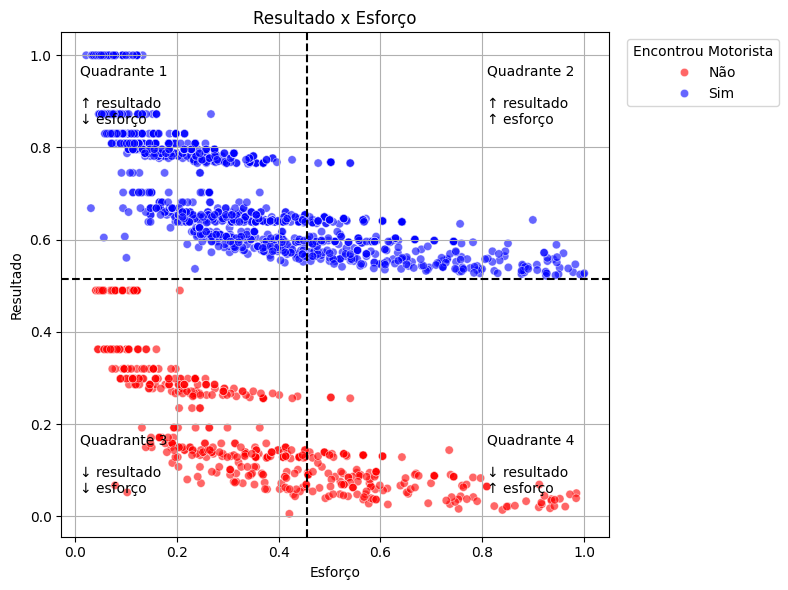

In [28]:
# resultado x esforço

# Criar um dicionário para mapear valores binários para texto
base_eficiencia['motorista_txt'] = base_eficiencia['encontrou_motorista'].map({0: 'Não', 1: 'Sim'})

plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(
    data=base_eficiencia,
    y='resultado',
    x='esforco',
    hue='motorista_txt',  # usar o texto mapeado
    palette={'Não': 'red', 'Sim': 'blue'},
    alpha=0.6
)

# Linhas de corte
plt.axvline(corte_esforco, color='black', linestyle='--')
plt.axhline(corte_resultado, color='black', linestyle='--')

# Zonas
plt.text(0.81, 0.05, 'Quadrante 4\n\n↓ resultado\n↑ esforço', fontsize=10)
plt.text(0.81, 0.85, 'Quadrante 2\n\n↑ resultado\n↑ esforço', fontsize=10)
plt.text(0.01, 0.05, 'Quadrante 3\n\n↓ resultado\n↓ esforço', fontsize=10)
plt.text(0.01, 0.85, 'Quadrante 1\n\n↑ resultado\n↓ esforço', fontsize=10)

# Ajustes finais
plt.title('Resultado x Esforço')
plt.ylabel('Resultado')
plt.xlabel('Esforço')
plt.grid(True)

# ✅ Legenda personalizada corretamente posicionada
plt.legend(title='Encontrou Motorista', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


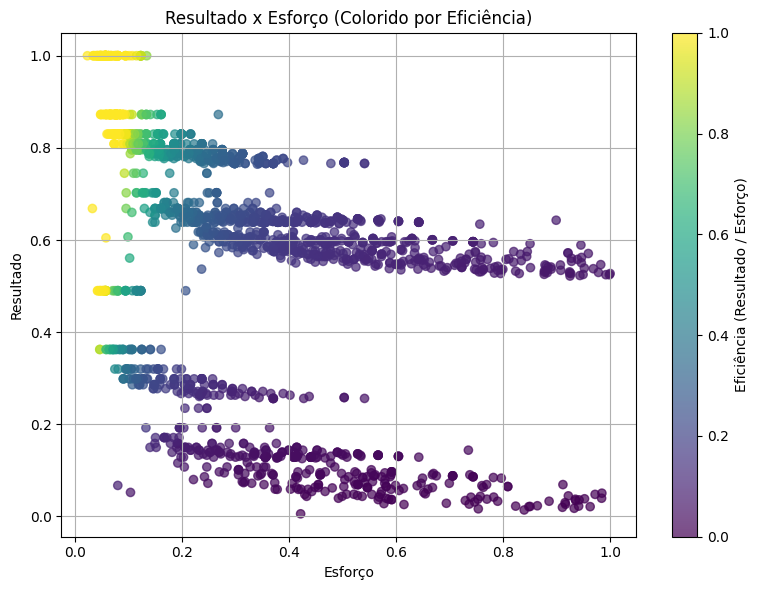

In [29]:
# Plotar scatter colorido por eficiência
plt.figure(figsize=(8, 6))
scatter = plt.scatter(base_eficiencia['esforco'], base_eficiencia['resultado'], c=base_eficiencia['eficiencia'], cmap='viridis', alpha=0.7)
# plt.axvline(x=0.4, linestyle='--', color='black')
# plt.axhline(y=0.5, linestyle='--', color='black')


# Títulos
plt.title("Resultado x Esforço (Colorido por Eficiência)")
plt.xlabel("Esforço")
plt.ylabel("Resultado")
plt.grid(True)

# Barra de cor
cbar = plt.colorbar(scatter)
cbar.set_label("Eficiência (Resultado / Esforço)")

plt.tight_layout()
plt.show()

TEOREMA DO MAURO

"90% DOS RESULTADOS VEM COM 10% DO ESFORÇO
 10% DOS RESULTADOS VEM COM 90% DO ESFORÇO"

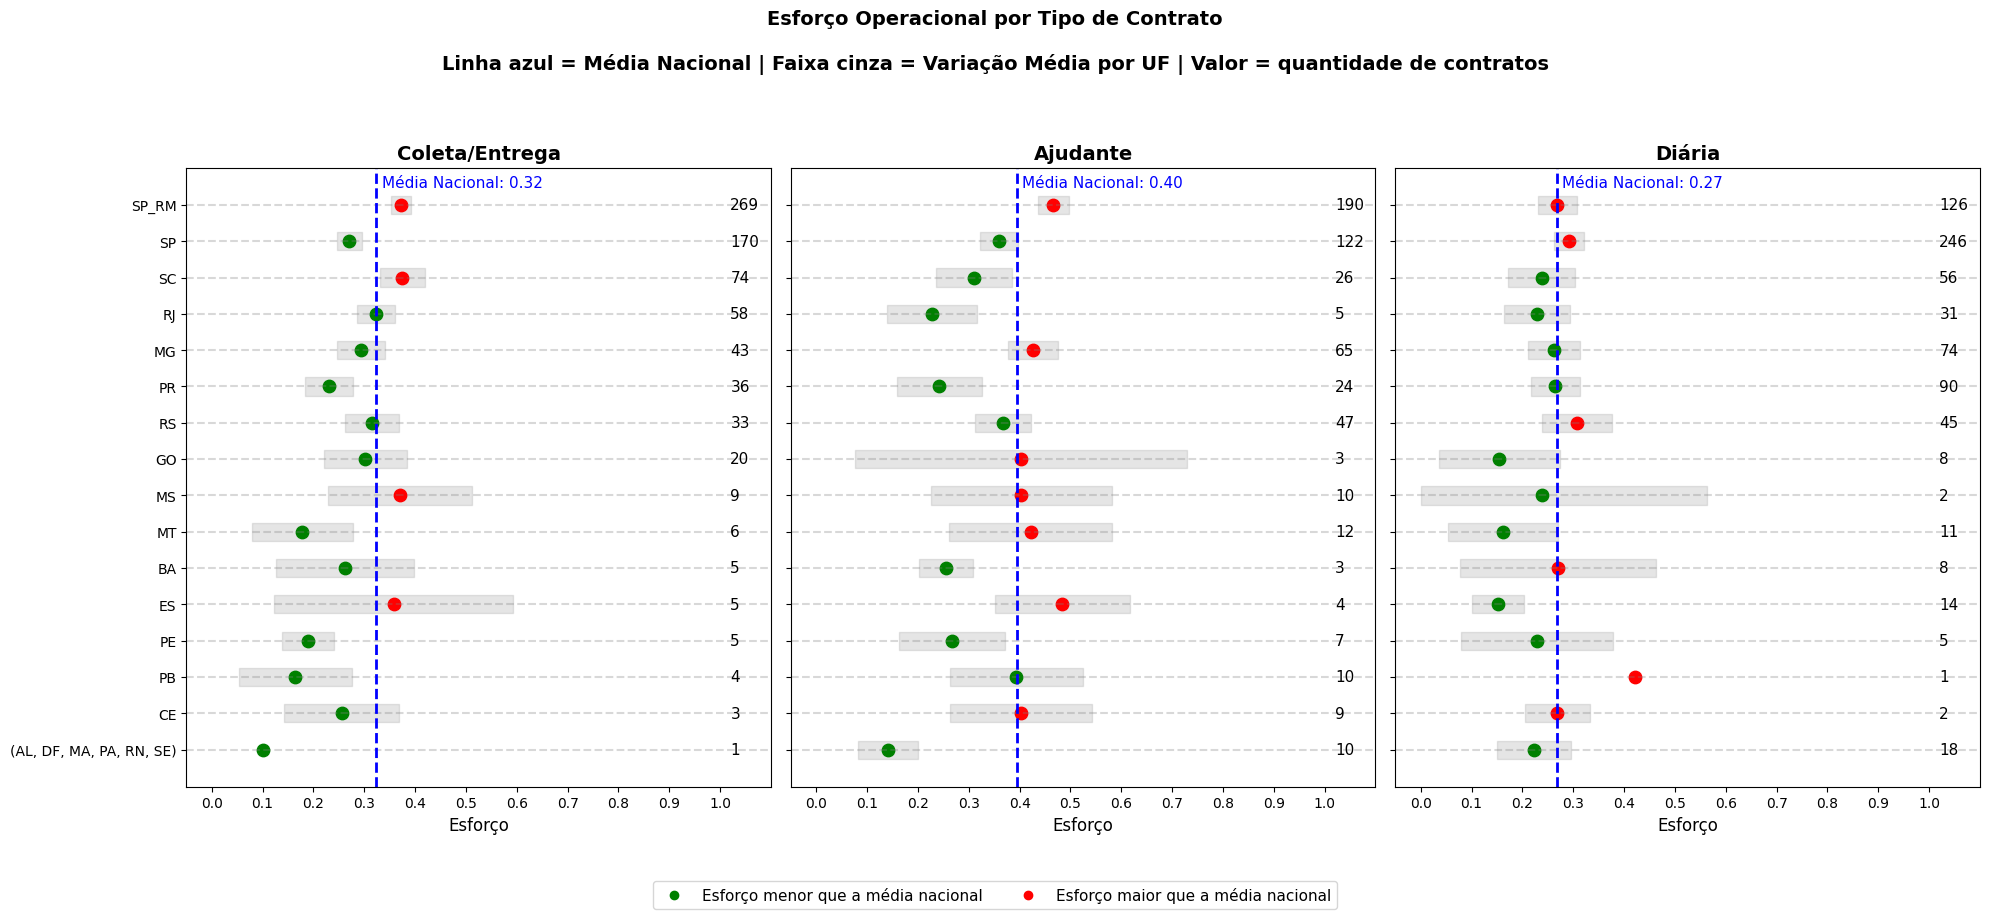

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem
import pandas as pd


base = base_eficiencia.copy()
tipos_contrato = base["de_type"].unique()

# Definir ordem dos estados com base na quantidade total de contratos do primeiro tipo
tipo_base = tipos_contrato[0]
ordem_uf = (
    base[base['de_type'] == tipo_base]
    .groupby("uf_ajustado")["esforco"]
    .count()
    .sort_values(ascending=False)
    .index.tolist()
)

# Plot
fig, axes = plt.subplots(1, len(tipos_contrato), figsize=(20, 8), sharey=True)

for i, tipo in enumerate(tipos_contrato):
    ax = axes[i]

    dados_filtro = base[base["de_type"] == tipo]

    estados = dados_filtro.groupby("uf_ajustado").agg(
        min=('esforco', 'min'),
        max=('esforco', 'max'),
        mean=('esforco', 'mean'),
        sem=('esforco', sem),
        qtde=('esforco', 'count')
    ).reset_index()

    estados["ic_inferior"] = (estados["mean"] - 1.96 * estados["sem"]).clip(0, 1)
    estados["ic_superior"] = (estados["mean"] + 1.96 * estados["sem"]).clip(0, 1)

    media_geral = dados_filtro["esforco"].mean()
    estados["cor"] = np.where(estados["mean"] >= media_geral, 'red', 'green')  # vermelho = mais esforço

    estados["ordem"] = estados["uf_ajustado"].apply(lambda x: ordem_uf.index(x) if x in ordem_uf else np.nan)
    estados = estados.dropna(subset=["ordem"]).sort_values("ordem")

    for _, row in estados.iterrows():
        y_pos = row["ordem"]
        cor = row["cor"]

        # Faixa sombreada
        ax.fill_betweenx([y_pos - 0.25, y_pos + 0.25],
                         row["ic_inferior"], row["ic_superior"],
                         color='gray', alpha=0.2)

        # Bolinha
        ax.scatter(row["mean"], y_pos, color=cor, s=80)

        # Quantidade de contratos à direita
        ax.text(
            1.02, y_pos,
            f"{int(row['qtde'])}",
            va='center',
            ha='left',
            fontsize=11,
            color='black'
        )

    for y in range(len(ordem_uf)):
        ax.axhline(y, color='gray', linestyle='--', alpha=0.3)

    # Linha da média nacional
    ax.axvline(media_geral, color='blue', linestyle='--', linewidth=2)
    ax.text(
        media_geral + 0.01, -0.5,
        f"Média Nacional: {media_geral:.2f}",
        color='blue',
        fontsize=11,
        ha='left'
    )

    ax.set_yticks(range(len(ordem_uf)))
    ax.set_yticklabels(ordem_uf)
    ax.invert_yaxis()

    ax.set_title(f"{tipo}", fontsize=14, fontweight='bold')
    ax.set_xlabel("Esforço", fontsize=12)
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.set_xlim(-0.05, 1.1)

plt.suptitle(
    "Esforço Operacional por Tipo de Contrato\n\n"
    "Linha azul = Média Nacional | Faixa cinza = Variação Média por UF | Valor = quantidade de contratos",
    fontsize=14,
    fontweight='bold',
    y=1.05
)

plt.figlegend(
    handles=[
        plt.Line2D([0], [0], color='green', marker='o', linestyle='None', label='Esforço menor que a média nacional'),
        plt.Line2D([0], [0], color='red', marker='o', linestyle='None', label='Esforço maior que a média nacional')
    ],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.03),
    ncol=2,
    fontsize=11
)

plt.tight_layout()
plt.show()


In [31]:


# Cópia da base
base = base_eficiencia.copy()

# Lista para armazenar os dados
resumo = []

# Iterar por tipo de contrato
for tipo in base["de_type"].unique():
    dados_tipo = base[base["de_type"] == tipo]
    
    # Média nacional de eficiência
    media_nacional = dados_tipo["esforco"].mean()

    # Média por UF
    medias_uf = dados_tipo.groupby("uf_ajustado")["esforco"].mean()

    # Contagem de estados acima e abaixo da média
    acima = (medias_uf > media_nacional).sum()
    abaixo = (medias_uf < media_nacional).sum()

    # Armazenar resultado
    resumo.append({
        "Tipo de Contrato": tipo,
        "Esforço Média": round(media_nacional, 2),
        "UFs Acima da Média": acima,
        "UFs Abaixo da Média": abaixo
    })

# Criar DataFrame resumo
resumo_df = pd.DataFrame(resumo)

# Exibir
print('COMPARATIVO ESFORÇO')
print(resumo_df)

COMPARATIVO ESFORÇO
  Tipo de Contrato  Esforço Média  UFs Acima da Média  UFs Abaixo da Média
0   Coleta/Entrega           0.32                   4                   12
1         Ajudante           0.40                   7                    9
2           Diária           0.27                   6                   10


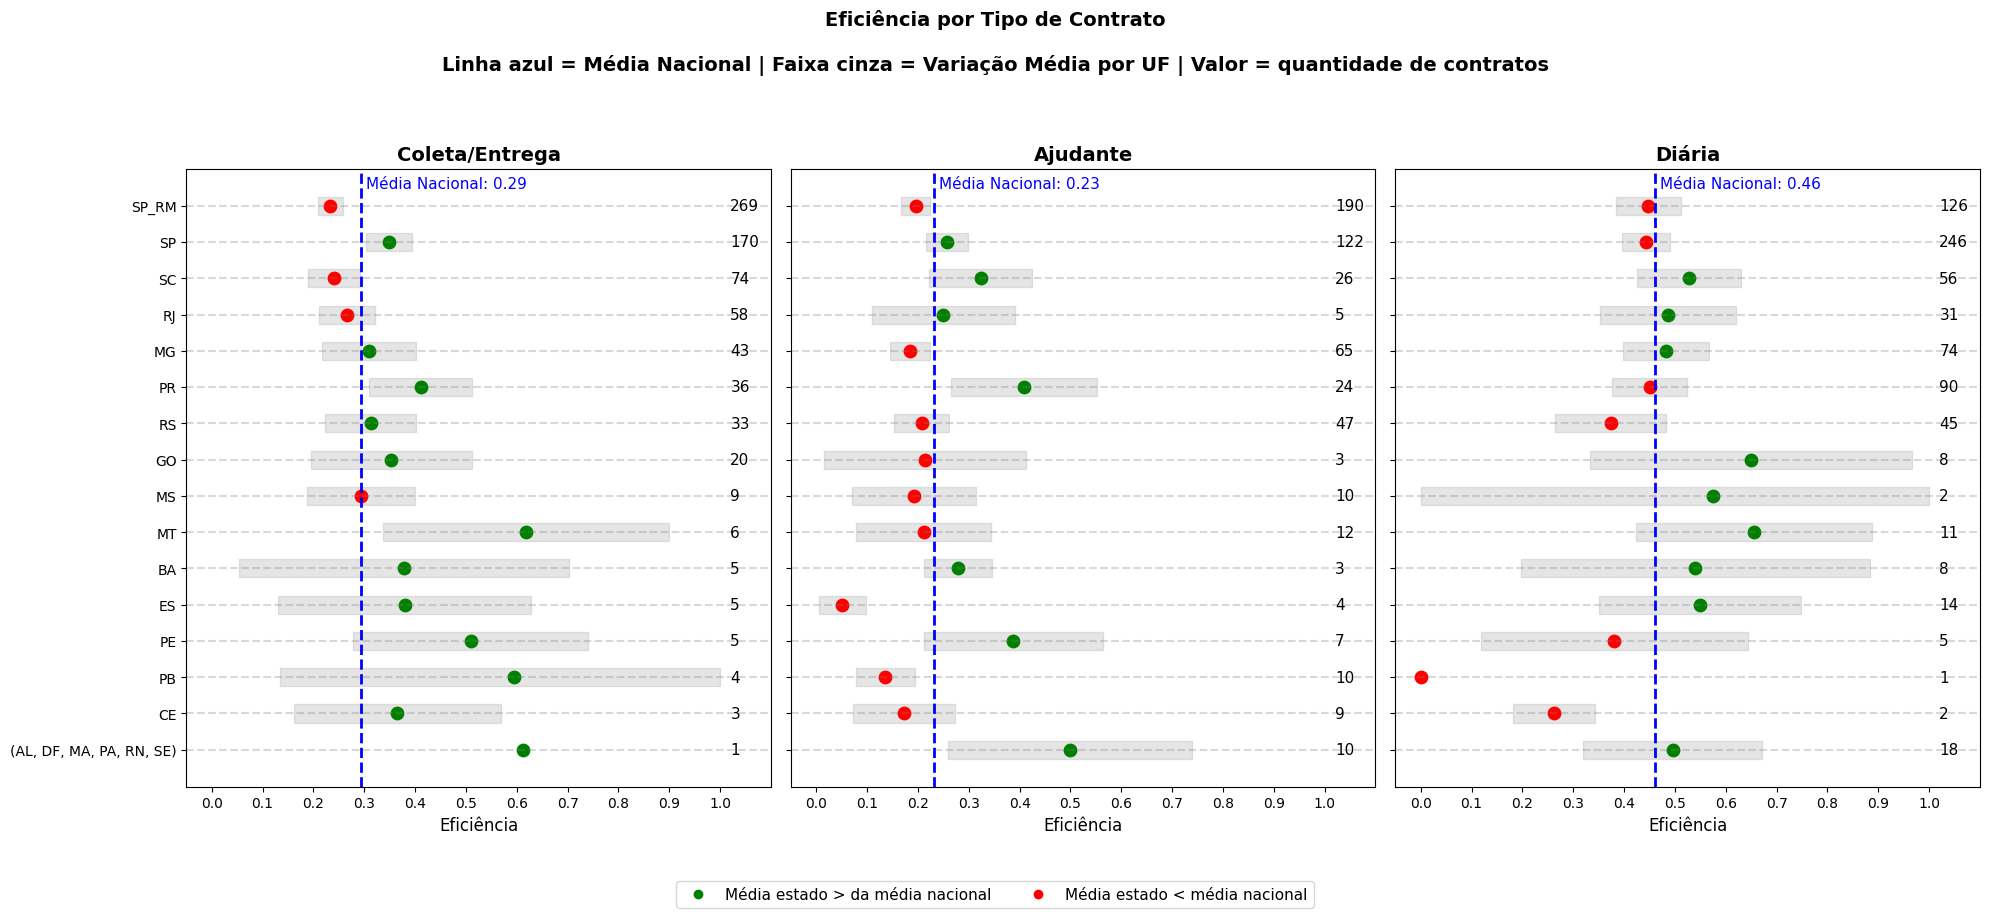

In [32]:
# grafico da eficiencia

base = base_eficiencia.copy()

tipos_contrato = base["de_type"].unique()

# Definir ordem dos estados com base na quantidade total de contratos do primeiro tipo
tipo_base = tipos_contrato[0]
ordem_uf = (
    base[base['de_type'] == tipo_base]
    .groupby("uf_ajustado")["eficiencia"]
    .count()
    .sort_values(ascending=False)
    .index.tolist()
)

# Plot
fig, axes = plt.subplots(1, len(tipos_contrato), figsize=(20, 8), sharey=True)

for i, tipo in enumerate(tipos_contrato):
    ax = axes[i]

    dados_filtro = base[base["de_type"] == tipo]

    estados = dados_filtro.groupby("uf_ajustado").agg(
        min=('eficiencia', 'min'),
        max=('eficiencia', 'max'),
        mean=('eficiencia', 'mean'),
        sem=('eficiencia', sem),
        qtde=('eficiencia', 'count')
    ).reset_index()

    estados["ic_inferior"] = (estados["mean"] - 1.96 * estados["sem"]).clip(0, 1)
    estados["ic_superior"] = (estados["mean"] + 1.96 * estados["sem"]).clip(0, 1)

    media_geral = dados_filtro["eficiencia"].mean()
    estados["cor"] = np.where(estados["mean"] >= media_geral, 'green', 'red')

    estados["ordem"] = estados["uf_ajustado"].apply(lambda x: ordem_uf.index(x) if x in ordem_uf else np.nan)
    estados = estados.dropna(subset=["ordem"]).sort_values("ordem")

    for _, row in estados.iterrows():
        y_pos = row["ordem"]
        cor = row["cor"]

        # Faixa sombreada representando variação (não chamar de IC)
        ax.fill_betweenx([y_pos - 0.25, y_pos + 0.25],
                         row["ic_inferior"], row["ic_superior"],
                         color='gray', alpha=0.2)

        # Bolinha
        ax.scatter(row["mean"], y_pos, color=cor, s=80)

        # Quantidade de contratos à direita
        ax.text(
            1.02, y_pos,
            f"{int(row['qtde'])}",
            va='center',
            ha='left',
            fontsize=11,
            color='black'
        )

    # Linhas horizontais
    for y in range(len(ordem_uf)):
        ax.axhline(y, color='gray', linestyle='--', alpha=0.3)

    # Linha da média nacional (azul e espessa)
    ax.axvline(media_geral, color='blue', linestyle='--', linewidth=2)
    ax.text(
        media_geral + 0.01, -0.5,
        f"Média Nacional: {media_geral:.2f}",
        color='blue',
        fontsize=11,
        ha='left'
    )

    # Eixo Y em todos os gráficos
    ax.set_yticks(range(len(ordem_uf)))
    ax.set_yticklabels(ordem_uf)
    ax.invert_yaxis()

    # Layout
    ax.set_title(f"{tipo}", fontsize=14, fontweight='bold')
    ax.set_xlabel("Eficiência", fontsize=12)
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.set_xlim(-0.05, 1.1)

# Título e legenda
plt.suptitle(
    "Eficiência por Tipo de Contrato\n\n"
    "Linha azul = Média Nacional | Faixa cinza = Variação Média por UF | Valor = quantidade de contratos",
    fontsize=14,
    fontweight='bold',
    y=1.05
)

plt.figlegend(
    handles=[
        plt.Line2D([0], [0], color='green', marker='o', linestyle='None', label='Média estado > da média nacional'),
        plt.Line2D([0], [0], color='red', marker='o', linestyle='None', label='Média estado < média nacional')
    ],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.03),  # ⬅️ empurra a legenda para baixo do gráfico
    ncol=2,
    fontsize=11
)

plt.tight_layout()
plt.show()


In [33]:


# Cópia da base
base = base_eficiencia.copy()

# Lista para armazenar os dados
resumo = []

# Iterar por tipo de contrato
for tipo in base["de_type"].unique():
    dados_tipo = base[base["de_type"] == tipo]
    
    # Média nacional de eficiência
    media_nacional = dados_tipo["eficiencia"].mean()

    # Média por UF
    medias_uf = dados_tipo.groupby("uf_ajustado")["eficiencia"].mean()

    # Contagem de estados acima e abaixo da média
    acima = (medias_uf > media_nacional).sum()
    abaixo = (medias_uf < media_nacional).sum()

    # Armazenar resultado
    resumo.append({
        "Tipo de Contrato": tipo,
        "UFs Acima da Média": acima,
        "UFs Abaixo da Média": abaixo
    })

# Criar DataFrame resumo
resumo_df = pd.DataFrame(resumo)

# Exibir
print('COMPARATIVO EFICIÊNCIA')
print(resumo_df)


COMPARATIVO EFICIÊNCIA
  Tipo de Contrato  UFs Acima da Média  UFs Abaixo da Média
0   Coleta/Entrega                  12                    4
1         Ajudante                   7                    9
2           Diária                   9                    7


In [34]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
from geobr import read_state
from matplotlib.cm import Reds, Greens
from matplotlib.colors import Normalize, to_hex

def plot_mapa_desempenho_geral(base, coluna='eficiencia', titulo="Eficiência por UF (Todos os Tipos de Contrato)"):
    # Carregar mapa
    estados = read_state(year=2020)

    # Média geral
    media_geral = base[coluna].mean()

    # Agrupar por UF
    resumo_uf = (
        base.groupby("uf_ajustado")
        .agg(media_valor=(coluna, "mean"), qtde=("freight_id", "count"))
        .reset_index()
    )

    # Classificação de desempenho
    resumo_uf["desempenho"] = np.where(resumo_uf["media_valor"] >= media_geral, "acima", "abaixo")

    # Normalizar qtde para escala [0.3, 1] para evitar cores muito claras
    norm = Normalize(vmin=resumo_uf["qtde"].min(), vmax=resumo_uf["qtde"].max())
    resumo_uf["intensidade"] = resumo_uf["qtde"].apply(lambda x: 0.3 + 0.7 * norm(x))

    # Aplicar cores com colormap
    def cor(row):
        if row["desempenho"] == "acima":
            return to_hex(Greens(row["intensidade"]))
        elif row["desempenho"] == "abaixo":
            return to_hex(Reds(row["intensidade"]))
        return "#E0E0E0"

    resumo_uf["cor"] = resumo_uf.apply(cor, axis=1)

    # Juntar com mapa
    mapa = estados.merge(resumo_uf, how="left", left_on="abbrev_state", right_on="uf_ajustado")
    mapa["cor"] = mapa["cor"].fillna("#E0E0E0")

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    mapa.plot(ax=ax, color=mapa["cor"], edgecolor="white", linewidth=0.8)

    # Siglas
    for idx, row in mapa.iterrows():
        if pd.notnull(row["media_valor"]):
            centroide = row["geometry"].centroid
            plt.text(
                centroide.x, centroide.y,
                row["abbrev_state"],
                fontsize=9,
                ha='center',
                va='center',
                color='black'
            )

    # Legenda
    legenda = [
        Patch(facecolor=to_hex(Greens(0.8)), label="Acima da média"),
        Patch(facecolor=to_hex(Reds(0.8)), label="Abaixo da média"),
        Patch(facecolor="#E0E0E0", label="Sem dados")
    ]
    plt.legend(handles=legenda, title="Desempenho", loc="lower left", fontsize=10)

    plt.title(f"{titulo}\nCor proporcional à quantidade de contratos", fontsize=14, pad=20)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


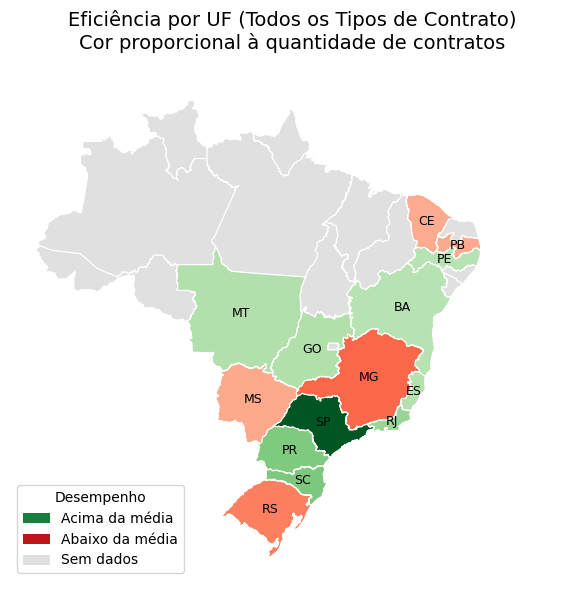

In [35]:
plot_mapa_desempenho_geral(base_eficiencia, coluna='eficiencia')

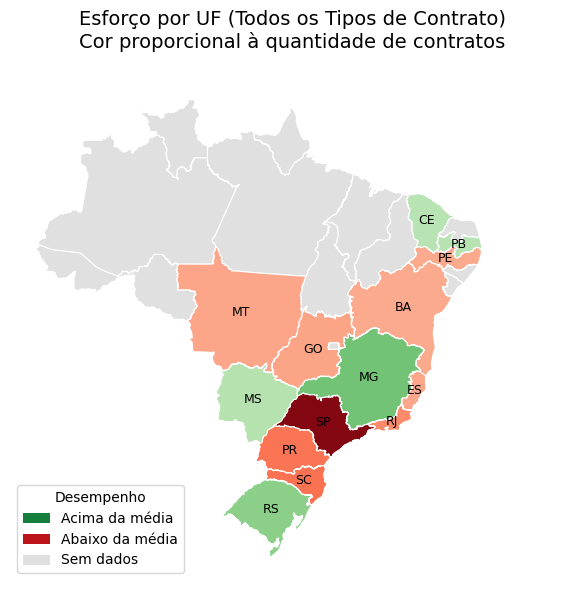

In [36]:
plot_mapa_desempenho_geral(base_eficiencia, coluna='esforco', titulo='Esforço por UF (Todos os Tipos de Contrato)')

# DISTRIBUIÇÃO DOS CONTRATOS

## arruamndo a base

In [37]:
# falcon

# total_falcon
contagem_mensal = base_eficiencia.groupby(['mes','de_type', 'uf']).agg(qt_contratos=('freight_id', 'nunique'),).reset_index()

esforco_mensal = base_eficiencia.groupby(['mes','de_type', 'uf']).agg(esforco =('esforco', 'mean'),).reset_index()

eficiencia_mensal = base_eficiencia.groupby(['mes','de_type', 'uf']).agg(eficiencia =('eficiencia', 'mean'),).reset_index()

falcon0 = contagem_mensal.merge(esforco_mensal, on=['mes','de_type', 'uf'], how='left').fillna(0)

falcon = falcon0.merge(eficiencia_mensal, on=['mes','de_type', 'uf'], how='left').fillna(0)

falcon.head(3)

,mes,de_type,uf,qt_contratos,esforco,eficiencia
0,2025-01-01,Ajudante,AL,2,0.08,0.84
1,2025-01-01,Ajudante,CE,4,0.52,0.18
2,2025-01-01,Ajudante,DF,2,0.16,0.17


In [38]:
# falcon_mes

falcon_mes = falcon.groupby(["uf", 'de_type'], as_index=False).agg({
    "qt_contratos": "mean",
    "esforco": "mean",
    "eficiencia": "mean",
}).rename(columns={
    "contratos": "media_contratos",
    "esforco": "media_esforco",
    "eficiencia": "media_eficiencia",
})

# Calcular a participação percentual de cada categoria dentro de cada mesorregião
# media["participacao_categoria"] = media.groupby("meso")["contratos_media"].transform(lambda x: x / x.sum())

falcon_mes.head(3)

,uf,de_type,qt_contratos,media_esforco,media_eficiencia
0,AL,Ajudante,2.00,0.08,0.84
1,BA,Ajudante,1.50,0.25,0.28
2,BA,Coleta/Entrega,2.50,0.26,0.37


In [39]:
falcon_mes.loc[falcon_mes.de_type == 'Ajudante'].qt_contratos.sum()

191.33333333333334

# distribuindo por estado (SP RM e SP)

In [40]:
# Parâmetros ajustáveis
peso_esforco = 1.0
peso_contratos = 3.0
usar_normalizacao = True  # define se os desvios serão normalizados

# Pesos por tipo de contrato (prioridade)
pesos_tipo = {
    'Diária': 0.5,
    'Coleta/Entrega': 0.5,
    'Ajudante': 2.5
}

# Inicializar controle
total_esforco = {'D': 0, 'L': 0}
total_contratos = {
    'D': {tipo: 0 for tipo in pesos_tipo},
    'L': {tipo: 0 for tipo in pesos_tipo}
}
uf_responsavel = {}

# Pré-calcular totais máximos para normalização
max_esforco_total = falcon_mes['media_esforco'].sum()
max_contratos_total = falcon_mes['qt_contratos'].sum()

# Agrupar UFs por esforço total decrescente
ufs_agrupado = falcon_mes.groupby('uf').agg(
    media_esforco=('media_esforco', 'sum'),
    contratos_total=('qt_contratos', 'sum')
).sort_values(by='media_esforco', ascending=False).reset_index()

for _, row in ufs_agrupado.iterrows():
    uf = row['uf']
    df_uf = falcon_mes[falcon_mes['uf'] == uf]

    esforco_uf = df_uf['media_esforco'].sum()
    contratos_uf = df_uf.groupby('de_type')['qt_contratos'].sum().to_dict()

    # --- Avaliar atribuição para D ---
    esforco_D = total_esforco['D'] + esforco_uf
    esforco_L = total_esforco['L']
    desvio_esforco_D = abs(esforco_D - esforco_L)
    if usar_normalizacao:
        desvio_esforco_D /= max_esforco_total

    contratos_D_temp = total_contratos['D'].copy()
    for tipo in contratos_uf:
        contratos_D_temp[tipo] += contratos_uf[tipo]

    desvio_contratos_D = sum([
        pesos_tipo[t] * abs(contratos_D_temp[t] - total_contratos['L'][t])
        for t in contratos_D_temp
    ])
    if usar_normalizacao:
        desvio_contratos_D /= max_contratos_total

    total_desvio_D = peso_esforco * desvio_esforco_D + peso_contratos * desvio_contratos_D

    # --- Avaliar atribuição para L ---
    esforco_D_alt = total_esforco['D']
    esforco_L_alt = total_esforco['L'] + esforco_uf
    desvio_esforco_L = abs(esforco_D_alt - esforco_L_alt)
    if usar_normalizacao:
        desvio_esforco_L /= max_esforco_total

    contratos_L_temp = total_contratos['L'].copy()
    for tipo in contratos_uf:
        contratos_L_temp[tipo] += contratos_uf[tipo]

    desvio_contratos_L = sum([
        pesos_tipo[t] * abs(total_contratos['D'][t] - contratos_L_temp[t])
        for t in contratos_L_temp
    ])
    if usar_normalizacao:
        desvio_contratos_L /= max_contratos_total

    total_desvio_L = peso_esforco * desvio_esforco_L + peso_contratos * desvio_contratos_L

    # --- Atribuir UF para menor desvio total ---
    if total_desvio_D <= total_desvio_L:
        responsavel = 'D'
        total_esforco['D'] += esforco_uf
        for tipo in contratos_uf:
            total_contratos['D'][tipo] += contratos_uf[tipo]
    else:
        responsavel = 'L'
        total_esforco['L'] += esforco_uf
        for tipo in contratos_uf:
            total_contratos['L'][tipo] += contratos_uf[tipo]

    uf_responsavel[uf] = responsavel

# Atribuir responsável na base
falcon_mes['responsavel'] = falcon_mes['uf'].map(uf_responsavel)

# Tabelas resumo
crosstab_contratos = falcon_mes.pivot_table(
    index='responsavel',
    columns='de_type',
    values='qt_contratos',
    aggfunc='sum',
    fill_value=0
)

crosstab_esforco = falcon_mes.groupby('responsavel')['media_esforco'].sum().to_frame('media_esforco')

# Resultados finais
print("🎯 Esforço total atribuído:")
print(total_esforco)

esforco_d = total_esforco['D']
esforco_l = total_esforco['L']

if esforco_l < esforco_d:
    diferenca_pct = ((esforco_d - esforco_l) / esforco_d) * 100
    print(f"O esforço do Leonardo é {diferenca_pct:.1f}% menor que o do Donegá.")
elif esforco_d < esforco_l:
    diferenca_pct = ((esforco_l - esforco_d) / esforco_l) * 100
    print(f"O esforço do Donegá é {diferenca_pct:.1f}% menor que o do Leonardo.")
else:
    print("Os esforços de Leonardo e Donegá são iguais.")

print("\n📦 Contratos por tipo (com pesos aplicados):")
print(pd.DataFrame(total_contratos).T)

#print("\n📍 Atribuição por UF:")
df_uf_responsavel = pd.DataFrame.from_dict(uf_responsavel, orient='index', columns=['responsavel']).sort_index()
# display(df_uf_responsavel)


🎯 Esforço total atribuído:
{'D': 8.253199430190259, 'L': 6.80911136935466}
O esforço do Leonardo é 17.5% menor que o do Donegá.

📦 Contratos por tipo (com pesos aplicados):
   Diária  Coleta/Entrega  Ajudante
D  102.00          137.33     96.17
L  151.83          113.17     95.17


In [41]:
# 📊 Tabela de contratos como porcentagem do total
crosstab_contratos_pct = falcon_mes.pivot_table(
    index='responsavel',
    columns='de_type',
    values='qt_contratos',
    aggfunc='sum',
    fill_value=0
)

# 🔢 Converter para porcentagem do total geral
total_geral = crosstab_contratos_pct.values.sum()
crosstab_contratos_pct = (crosstab_contratos_pct / total_geral * 100).round(1)

# ➕ Adicionar coluna de soma por responsável
crosstab_contratos_pct["Total (%)"] = crosstab_contratos_pct.sum(axis=1).round(1)

# ✅ Exibir
print("📊 Distribuição percentual dos contratos por tipo e responsável:")
print(crosstab_contratos_pct)



📊 Distribuição percentual dos contratos por tipo e responsável:
de_type      Ajudante  Coleta/Entrega  Diária  Total (%)
responsavel                                             
D               13.80           19.70   14.70      48.20
L               13.70           16.30   21.80      51.80


In [42]:
resumo_final = falcon_mes.copy()

# Unificar SP e SP_RM para visualização por estado
resumo_final['uf_plot'] = resumo_final['uf'].replace('SP_RM', 'SP')

# Agrupar por estado e responsável
resumo_final = resumo_final.groupby(['uf_plot', 'responsavel']).apply(
    lambda x: pd.Series({
        
        'media_ponderada_esforco': np.average(x['media_esforco'], weights=x['qt_contratos'])
    })
).reset_index().rename(columns={'uf_plot': 'uf'})
resumo_final.head(3)

,uf,responsavel,media_ponderada_esforco
0,AL,D,0.08
1,BA,D,0.29
2,CE,D,0.31


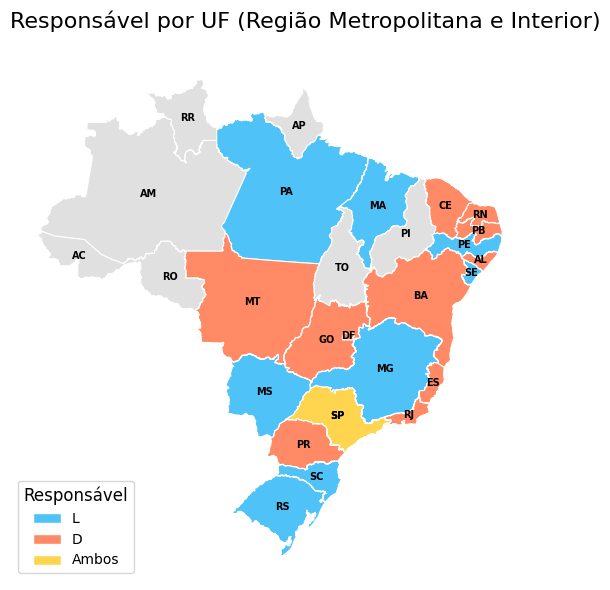

In [43]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from geobr import read_state

# Carregar estados
states = read_state(year=2020)

# Substituir SP_RM por SP para unificar
resumo_final['uf_plot'] = resumo_final['uf'].replace('SP_RM', 'SP')

# Juntar com mapa
mapa = states.merge(resumo_final, left_on='abbrev_state', right_on='uf_plot', how='left')

# Marcar SP
mapa['is_sp'] = mapa['abbrev_state'] == 'SP'

# Cores atualizadas
cores_responsavel = {
    'D': '#FF8A65',  # Laranja
    'L': '#4FC3F7',  # Azul
    'Ambos': '#FFD54F',  # Amarelo claro para SP (Ambos)
    None: '#E0E0E0'  # Cinza claro para ausentes
}

# SP como “Ambos” na legenda
mapa['responsavel_plot'] = mapa.apply(
    lambda row: 'Ambos' if row['is_sp'] else row['responsavel'],
    axis=1
)

# Aplicar cores
mapa['cor'] = mapa['responsavel_plot'].map(cores_responsavel).fillna(cores_responsavel[None])

# Criar figura
fig, ax = plt.subplots(figsize=(8, 6))

# Plotar estados com cor de fundo
mapa.plot(
    ax=ax,
    color=mapa['cor'],
    edgecolor='white',
    linewidth=0.8,
    zorder=2
)

# Letras com sigla de UF (centralizadas)
for idx, row in mapa.iterrows():
    centroid = row['geometry'].centroid
    plt.text(
        centroid.x,
        centroid.y,
        row['abbrev_state'],
        fontsize=7,
        fontweight='bold',
        ha='center',
        va='center',
        color='black',
        zorder=5
    )

# Legenda
legenda = [
    Patch(facecolor=cores_responsavel['L'], edgecolor='white', label='L'),
    Patch(facecolor=cores_responsavel['D'], edgecolor='white', label='D'),
    Patch(facecolor=cores_responsavel['Ambos'], edgecolor='white', label='Ambos')
]
plt.legend(handles=legenda, title='Responsável', loc='lower left', fontsize=10, title_fontsize=12)

# Título e layout
plt.title("Responsável por UF (Região Metropolitana e Interior)", fontsize=16, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()


# distribuindo por estado (equilibrando quantidade de contratos)

In [44]:
# falcon_sp_unico
falcon_sp_unico = falcon_mes.copy()

# Substituir 'SP_RM' por 'SP' na coluna 'uf'
falcon_sp_unico['uf'] = falcon_sp_unico['uf'].replace('SP_RM', 'SP')

# Remover a coluna 'responsavel' se ela existir
falcon_sp_unico = falcon_sp_unico.drop(columns=['responsavel'], errors='ignore')

# Agrupar por uf e de_type, somando qt_contratos e calculando média de media_esforco
falcon_sp_unico = falcon_sp_unico.groupby(['uf', 'de_type']).agg({
    'qt_contratos': 'sum',
    'media_esforco': 'mean'
}).reset_index()
falcon_sp_unico.to_csv('falcon_sp_unico.csv', index=False)
falcon_sp_unico.head(3)

,uf,de_type,qt_contratos,media_esforco
0,AL,Ajudante,2.00,0.08
1,BA,Ajudante,1.50,0.25
2,BA,Coleta/Entrega,2.50,0.26


In [45]:
# funcao que distribui

def distribuir_ufs_plotar_mapa(
    falcon_sp_unico,
    peso_esforco,
    peso_contratos,
    usar_normalizacao,
    pesos_tipo,
    nome_responsavel_L='L',
    nome_responsavel_D='D'
):
    # Inicializar controle
    total_esforco = {'D': 0, 'L': 0}
    total_contratos = {
        'D': {tipo: 0 for tipo in pesos_tipo},
        'L': {tipo: 0 for tipo in pesos_tipo}
    }
    uf_responsavel = {}

    max_esforco_total = falcon_sp_unico['media_esforco'].sum()

    ufs_agrupado = falcon_sp_unico.groupby('uf').agg(
        media_esforco=('media_esforco', 'sum'),
        contratos_total=('qt_contratos', 'sum')
    ).sort_values(by='contratos_total', ascending=False).reset_index()

    for _, row in ufs_agrupado.iterrows():
        uf = row['uf']
        df_uf = falcon_sp_unico[falcon_sp_unico['uf'] == uf]

        esforco_uf = df_uf['media_esforco'].sum()
        contratos_uf = df_uf.groupby('de_type')['qt_contratos'].sum().to_dict()

        esforco_D = total_esforco['D'] + esforco_uf
        desvio_esforco_D = abs(esforco_D - total_esforco['L'])
        if usar_normalizacao:
            desvio_esforco_D /= max_esforco_total

        contratos_D_temp = total_contratos['D'].copy()
        for tipo in contratos_uf:
            contratos_D_temp[tipo] += contratos_uf[tipo]

        desvio_contratos_D = sum([
            pesos_tipo[t] * abs(contratos_D_temp[t] - total_contratos['L'][t]) / max(1, contratos_D_temp[t] + total_contratos['L'][t])
            for t in contratos_D_temp
        ])
        if usar_normalizacao:
            desvio_contratos_D /= len(pesos_tipo)

        total_desvio_D = peso_esforco * desvio_esforco_D + peso_contratos * desvio_contratos_D

        esforco_L = total_esforco['L'] + esforco_uf
        desvio_esforco_L = abs(total_esforco['D'] - esforco_L)
        if usar_normalizacao:
            desvio_esforco_L /= max_esforco_total

        contratos_L_temp = total_contratos['L'].copy()
        for tipo in contratos_uf:
            contratos_L_temp[tipo] += contratos_uf[tipo]

        desvio_contratos_L = sum([
            pesos_tipo[t] * abs(total_contratos['D'][t] - contratos_L_temp[t]) / max(1, total_contratos['D'][t] + contratos_L_temp[t])
            for t in contratos_L_temp
        ])
        if usar_normalizacao:
            desvio_contratos_L /= len(pesos_tipo)

        total_desvio_L = peso_esforco * desvio_esforco_L + peso_contratos * desvio_contratos_L

        if total_desvio_D <= total_desvio_L:
            responsavel = 'D'
            total_esforco['D'] += esforco_uf
            for tipo in contratos_uf:
                total_contratos['D'][tipo] += contratos_uf[tipo]
        else:
            responsavel = 'L'
            total_esforco['L'] += esforco_uf
            for tipo in contratos_uf:
                total_contratos['L'][tipo] += contratos_uf[tipo]

        uf_responsavel[uf] = responsavel

    # Atualiza base
    falcon_sp_unico['responsavel'] = falcon_sp_unico['uf'].map(uf_responsavel)

    # --- Resultados finais ---
    print("🎯 Esforço total atribuído:")
    print(total_esforco)


    # --- Plotagem do mapa ---
    resumo_final = pd.DataFrame.from_dict(uf_responsavel, orient='index', columns=['responsavel']).reset_index().rename(columns={'index': 'uf_plot'})
    states = read_state(year=2020)
    mapa = states.merge(resumo_final, left_on='abbrev_state', right_on='uf_plot', how='left')

    cores_responsavel = {
        'D': '#FF8A65',  # Responsável 2
        'L': '#4FC3F7',  # Responsável 1
        None: '#E0E0E0'
    }
    mapa['cor'] = mapa['responsavel'].map(cores_responsavel).fillna(cores_responsavel[None])

    fig, ax = plt.subplots(figsize=(8, 6))
    mapa.plot(ax=ax, color=mapa['cor'], edgecolor='white', linewidth=0.8, zorder=2)

    # UFs pequenas para reduzir fonte
    ufs_pequenas = ['DF', 'SE', 'AL', 'ES', 'RJ']

    for _, row in mapa.iterrows():
        if row['geometry'].is_empty or row['geometry'] is None:
            continue
        centroid = row['geometry'].centroid
        sigla = row['abbrev_state']
        fontsize = 7 if sigla not in ufs_pequenas else 7

        plt.text(
            centroid.x,
            centroid.y,
            sigla,
            fontsize=fontsize,
            fontweight='bold',
            ha='center',
            va='center',
            color='black',
            zorder=5
        )

    legenda = [
        Patch(facecolor=cores_responsavel['L'], edgecolor='white', label=nome_responsavel_L),
        Patch(facecolor=cores_responsavel['D'], edgecolor='white', label=nome_responsavel_D),
    ]
    plt.legend(handles=legenda, title='Responsável', loc='lower left', fontsize=10, title_fontsize=12)
    plt.title("Responsável por UF", fontsize=16, pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # 💬 Comparação automática do esforço
    esforco_d = total_esforco['D']
    esforco_l = total_esforco['L']

    if esforco_l < esforco_d:
        diferenca_pct = ((esforco_d - esforco_l) / esforco_d) * 100
        print(f"\n📉 O esforço do Leonardo é {diferenca_pct:.1f}% menor que o do Donegá.")
    elif esforco_d < esforco_l:
        diferenca_pct = ((esforco_l - esforco_d) / esforco_l) * 100
        print(f"\n📉 O esforço do Donegá é {diferenca_pct:.1f}% menor que o do Leonardo.")
    else:
        print("\n⚖️ Os esforços de Leonardo e Donegá são iguais.")

    return falcon_sp_unico, total_esforco, total_contratos, uf_responsavel


🎯 Esforço total atribuído:
{'D': 4.966185950373724, 'L': 9.081636211357145}


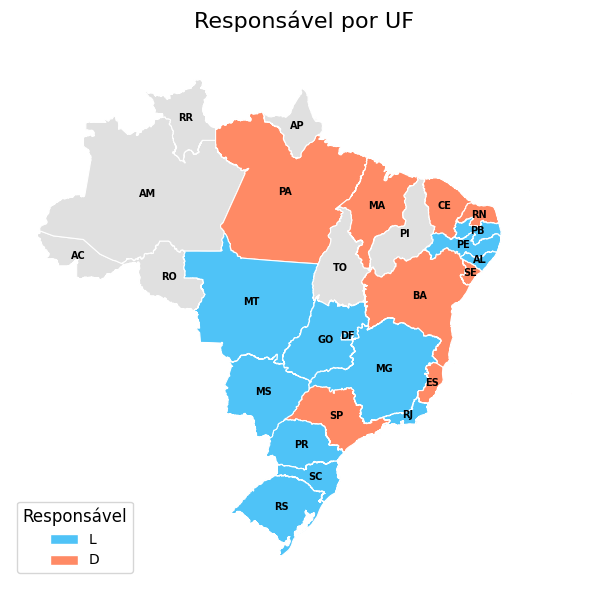


📉 O esforço do Donegá é 45.3% menor que o do Leonardo.


In [46]:
# priorizando equilibrio contratos
falcon_sp_unico_resultado, esforco, contratos, atribuicoes = distribuir_ufs_plotar_mapa(
    falcon_sp_unico,
    peso_esforco=1,
    peso_contratos=3,
    usar_normalizacao=True,
    pesos_tipo={
        'Diária': 0.5,
        'Coleta/Entrega': 2.5,
        'Ajudante': 2.5
    },
)


In [47]:
# 📊 Tabela de contratos como porcentagem do total
crosstab_contratos_pct = falcon_sp_unico.pivot_table(
    index='responsavel',
    columns='de_type',
    values='qt_contratos',
    aggfunc='sum',
    fill_value=0
)

# 🔢 Converter para porcentagem do total geral
total_geral = crosstab_contratos_pct.values.sum()
crosstab_contratos_pct = (crosstab_contratos_pct / total_geral * 100).round(1)

# ➕ Adicionar coluna de soma por responsável
crosstab_contratos_pct["Total (%)"] = crosstab_contratos_pct.sum(axis=1).round(1)

# ✅ Exibir
print("📊 Distribuição percentual dos contratos por tipo e responsável:")
print(crosstab_contratos_pct)

📊 Distribuição percentual dos contratos por tipo e responsável:
de_type      Ajudante  Coleta/Entrega  Diária  Total (%)
responsavel                                             
D               16.10           22.00   20.30      58.40
L               11.40           14.00   16.20      41.60


## como é hoje

In [48]:
falcon_atual = falcon_mes.copy()

falcon_atual["responsavel"] = falcon_atual["de_type"].apply(lambda x: "D" if x == "Diária" else "L")

falcon_atual.head(3)

,uf,de_type,qt_contratos,media_esforco,media_eficiencia,responsavel
0,AL,Ajudante,2.00,0.08,0.84,L
1,BA,Ajudante,1.50,0.25,0.28,L
2,BA,Coleta/Entrega,2.50,0.26,0.37,L


In [49]:
# Supondo que falcon_atual já contenha: uf, de_type, qt_contratos, media_esforco, responsavel

# ✅ Pesos por tipo de contrato (ajuste conforme necessário)
pesos_tipo = {
    'Diária': 1.0,
    'Coleta/Entrega': 1.0,
    'Ajudante': 1.0
}

# 🎯 Inicializar dicionários
total_esforco = {'D': 0, 'L': 0}
total_contratos = {
    'D': {tipo: 0 for tipo in pesos_tipo},
    'L': {tipo: 0 for tipo in pesos_tipo}
}

# 🔄 Agrupar e acumular
for _, row in falcon_atual.iterrows():
    responsavel = row['responsavel']
    tipo = row['de_type']
    contratos = row['qt_contratos']
    esforco = row['media_esforco']
    
    total_esforco[responsavel] += esforco
    total_contratos[responsavel][tipo] += contratos * pesos_tipo[tipo]  # peso aplicado

# ✅ Mostrar resultados
print("🎯 Esforço total atribuído:")
print(total_esforco)

# Cálculo automático da diferença percentual entre os esforços
esforco_d = total_esforco['D']
esforco_l = total_esforco['L']

if esforco_l < esforco_d:
    diferenca_pct = ((esforco_d - esforco_l) / esforco_d) * 100
    print(f"O esforço do Leonardo é {diferenca_pct:.1f}% menor que o do Donegá.")
elif esforco_d < esforco_l:
    diferenca_pct = ((esforco_l - esforco_d) / esforco_l) * 100
    print(f"O esforço do Donegá é {diferenca_pct:.1f}% menor que o do Leonardo.")
else:
    print("Os esforços de Leonardo e Donegá são iguais.")


print("\n📦 Contratos por tipo (com pesos aplicados):")
print(pd.DataFrame(total_contratos).T)


🎯 Esforço total atribuído:
{'D': 4.931037089491809, 'L': 10.13127371005311}
O esforço do Donegá é 51.3% menor que o do Leonardo.

📦 Contratos por tipo (com pesos aplicados):
   Diária  Coleta/Entrega  Ajudante
D  253.83            0.00      0.00
L    0.00          250.50    191.33


In [51]:
# 📊 Tabela de contratos como porcentagem do total
crosstab_contratos_pct = falcon_atual.pivot_table(
    index='responsavel',
    columns='de_type',
    values='qt_contratos',
    aggfunc='sum',
    fill_value=0
)

# 🔢 Converter para porcentagem do total geral
total_geral = crosstab_contratos_pct.values.sum()
crosstab_contratos_pct = (crosstab_contratos_pct / total_geral * 100).round(1)
crosstab_contratos_pct["Total (%)"] = crosstab_contratos_pct.sum(axis=1).round(1)

# ✅ Exibir
print("📊 Distribuição percentual dos contratos por tipo e responsável:")
print(crosstab_contratos_pct)

📊 Distribuição percentual dos contratos por tipo e responsável:
de_type      Ajudante  Coleta/Entrega  Diária  Total (%)
responsavel                                             
D                0.00            0.00   36.50      36.50
L               27.50           36.00    0.00      63.50
